<div class="alert alert-block alert-success">
<h1>Dependency on Multiyear Ice Concentration</h1></div>

**Student:** Kirsten Schulze <br>
**Email:** <kirsten.schulze@studium.uni-hamburg.de> <br>

**MSc Thesis in Ocean and Climate Physics** <br>
**Title:** Evaluation of Snow Depth Retrievals from Differences in ICESat-2 and CryoSat-2 Freeboards Using In-Situ Measurements in the Weddell Sea  <br>
**Supervisors:** Prof. Dr. Stefanie Arndt and Dr. Stefan Kern <br>
**Hamburg University** <br>


<div class="alert alert-info" role="alert">

## <a id="TOC_TOP"></a>Contents

</div>
    
1. [Multiyear Ice Concentration: Load Data](#section1)
1. [29 Matches: Load Data](#section2)
1. [Extract the 2x2 Box of Multiyear Ice Concentration for each Match](#section3)
1. [Analysis of Multiyear Ice Concentration Dependency](#section4)
    1. [Map of Multiyear Ice Concentration for 27 Matches](#section4.1)
    1. [Histogram of MYI Concentration](#section4.2)
    1. [Histogram of Snow Depth Differences](#section4.3)
    1. [Pearson and Spearman Correlation of all 27 Matches and without 2021S114 in 2021](#section4.4)
    1. [Pearson and Spearman Correlation of only MYI Snow Buoys](#section4.5)
    1. [Pearson and Spearman Correlation between Snow Depth Difference and 0% MYI](#section4.6)

<hr>

In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import xarray as xr
import netCDF4 as nc
import cartopy as cp

import cartopy.crs as ccrs 
import cartopy.feature as cfeature

import seaborn as sns
import scipy.stats as stats

import os

from scipy.stats import spearmanr
from scipy.spatial import cKDTree

from scipy.stats import shapiro 

In [2]:
plt.style.use("ggplot")

<div class="alert alert-info" role="alert">

## <a id="section1"></a>Multiyear Ice Concentration: Load Data
[Back to top](#TOC_TOP)

</div>

In [3]:
data_dir = "Sea Ice Age"
file_pattern = "MultiYearIce-Antarctic-*.nc"

file_paths = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith("MultiYearIce-Antarctic-") and f.endswith(".nc")])

# Extract timestamps 
times = [pd.to_datetime(f.split("-")[-1].split(".")[0], format="%Y%m%d") for f in file_paths]

#getting the lat and lon 
fname="Sea Ice Age/ECICE-IcetypesUncorrected-20190101.nc"
ds=xr.open_dataset(fname)
lon = ds["LON"]
lat = ds["LAT"]

datasets = []

# Load each dataset, add time, longitude, and latitude dimensions
for time, file_path in zip(times, file_paths):
    ds = xr.open_dataset(file_path)
    ds = ds.expand_dims({"time": [time]})  # Add time dimension
    ds = ds.assign_coords({"lon": lon, "lat": lat})  # Add lon and lat coordinates
    datasets.append(ds)

# Concatenate all datasets along the new time dimension
combined_ds = xr.concat(datasets, dim="time")

combined_ds


<xarray.Dataset>
Dimensions:  (time: 30, X: 664, Y: 632)
Coordinates:
  * time     (time) datetime64[ns] 2019-05-06 2019-05-22 ... 2022-08-17
    lon      (X, Y) float64 -42.24 -42.15 -42.06 -41.96 ... 135.2 135.1 135.0
    lat      (X, Y) float64 -39.3 -39.36 -39.43 -39.49 ... -41.65 -41.58 -41.52
Dimensions without coordinates: X, Y
Data variables:
    MYI      (time, X, Y) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CR-FLAG  (time, X, Y) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    EXMYI    (time, X, Y) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Convention:   None
    title:        Multiyear ice concentration from active and passive microwa...
    institution:  University of Bremen
    references:   http://www.seaice.uni-bremen.de/multiyear-ice-concentration
    grid_info:    NSIDC polar stereographic 12.5km grid, Antarctic, \n    see...
    comment:      Projection information: NSIDC Sea Ice Polar Stereographic S...

In [4]:
lon_box = [-70, 10]
lat_box = [-80, -60]

mask_lon = (combined_ds["lon"] >= lon_box[0]) & (combined_ds["lon"] <= lon_box[1])
mask_lat = (combined_ds["lat"] >= lat_box[0]) & (combined_ds["lat"] <= lat_box[1])

subset_ds = combined_ds.where(mask_lon & mask_lat, drop=True)
subset_ds

<xarray.Dataset>
Dimensions:  (time: 30, X: 236, Y: 296)
Coordinates:
  * time     (time) datetime64[ns] 2019-05-06 2019-05-22 ... 2022-08-17
    lon      (X, Y) float64 -43.22 -43.11 -42.99 -42.87 ... 54.96 55.57 56.16
    lat      (X, Y) float64 -49.65 -49.72 -49.79 -49.86 ... -83.88 -83.78 -83.69
Dimensions without coordinates: X, Y
Data variables:
    MYI      (time, X, Y) float32 nan nan nan nan nan ... nan nan nan nan nan
    CR-FLAG  (time, X, Y) float64 nan nan nan nan nan ... nan nan nan nan nan
    EXMYI    (time, X, Y) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Convention:   None
    title:        Multiyear ice concentration from active and passive microwa...
    institution:  University of Bremen
    references:   http://www.seaice.uni-bremen.de/multiyear-ice-concentration
    grid_info:    NSIDC polar stereographic 12.5km grid, Antarctic, \n    see...
    comment:      Projection information: NSIDC Sea Ice Polar Stereographic S...

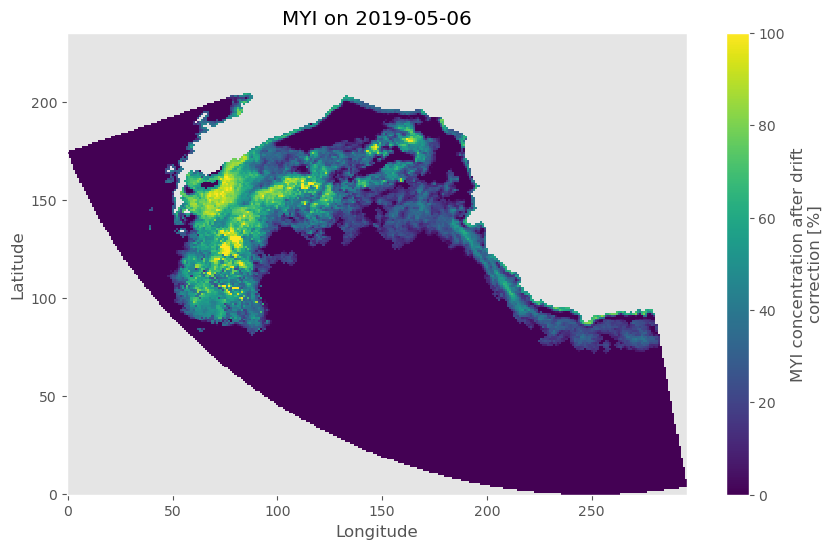

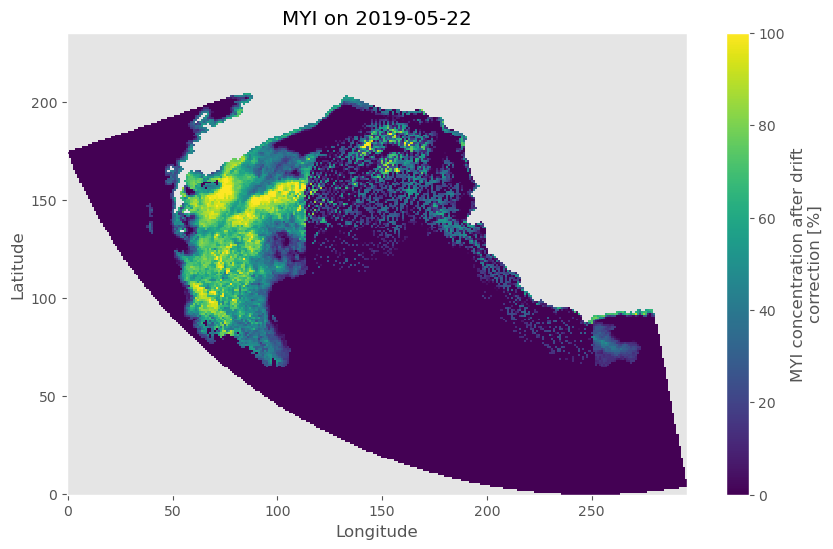

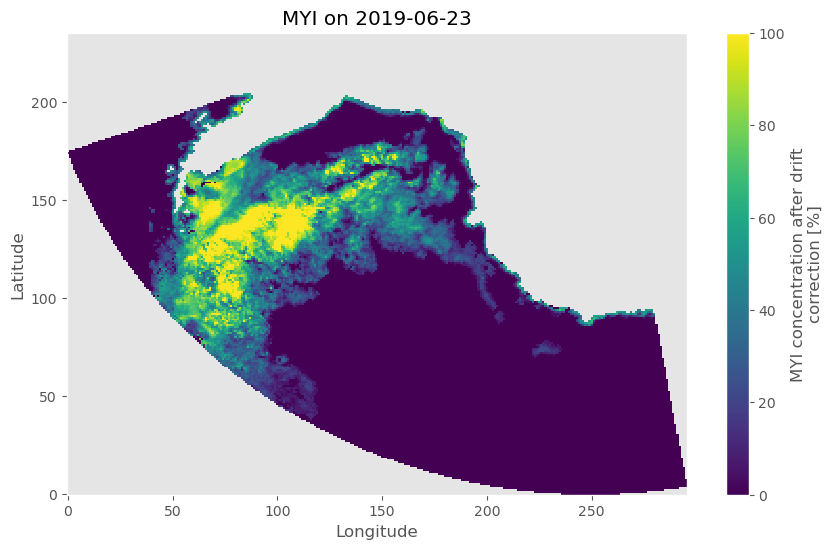

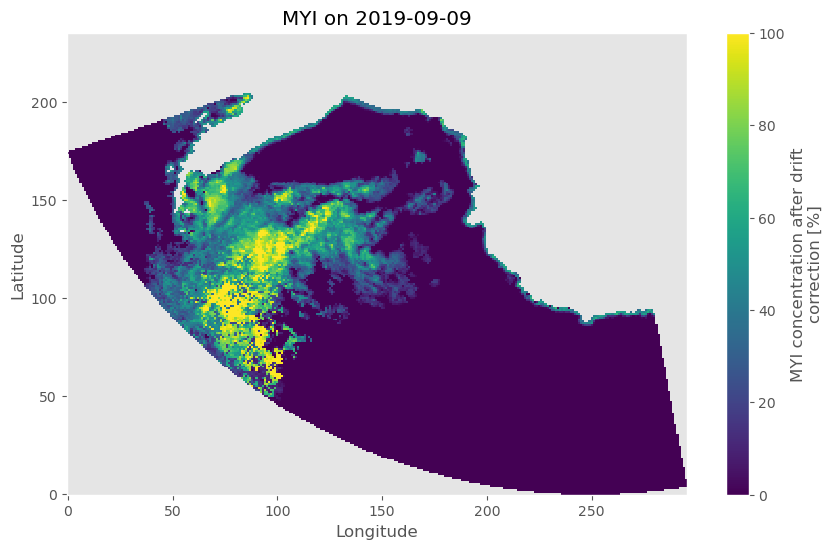

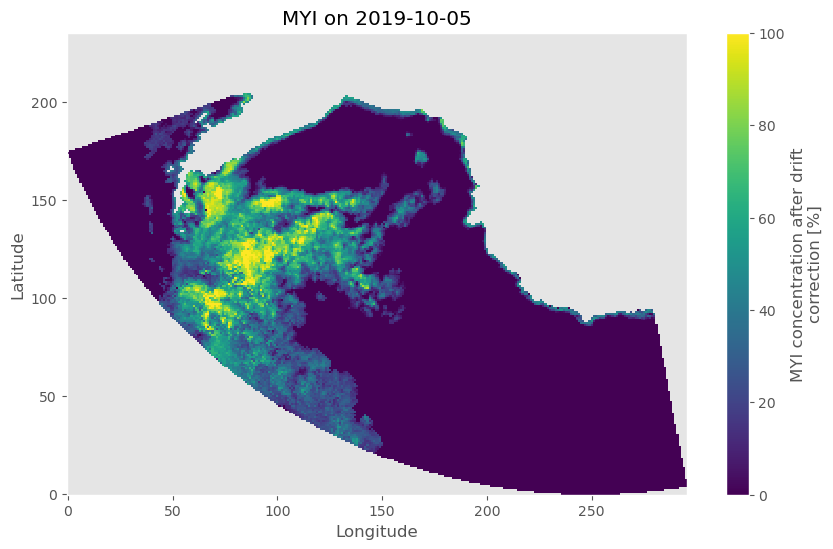

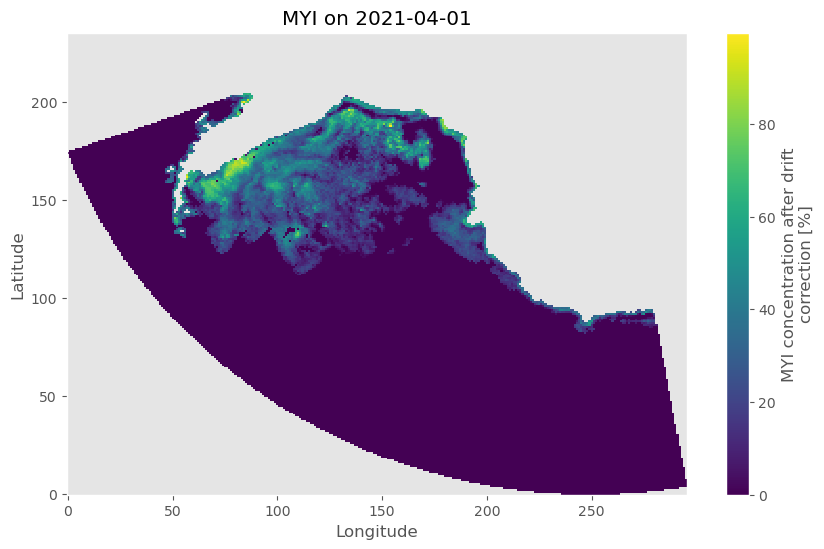

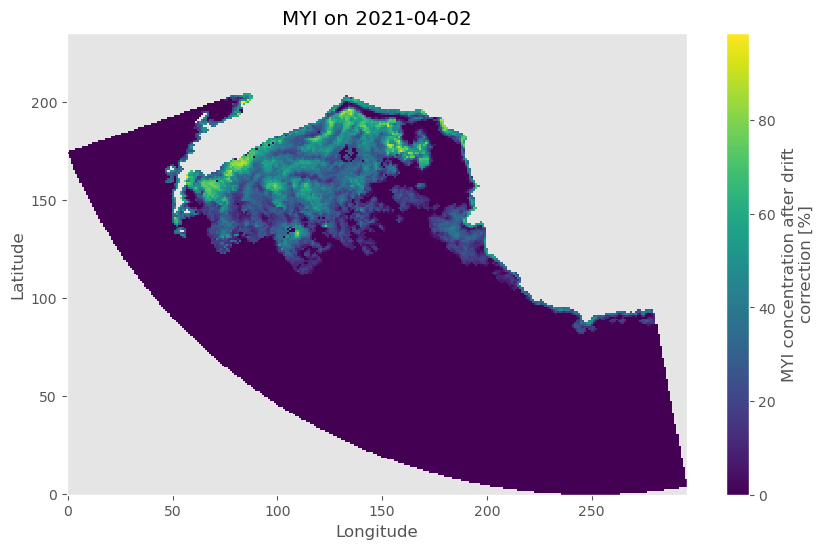

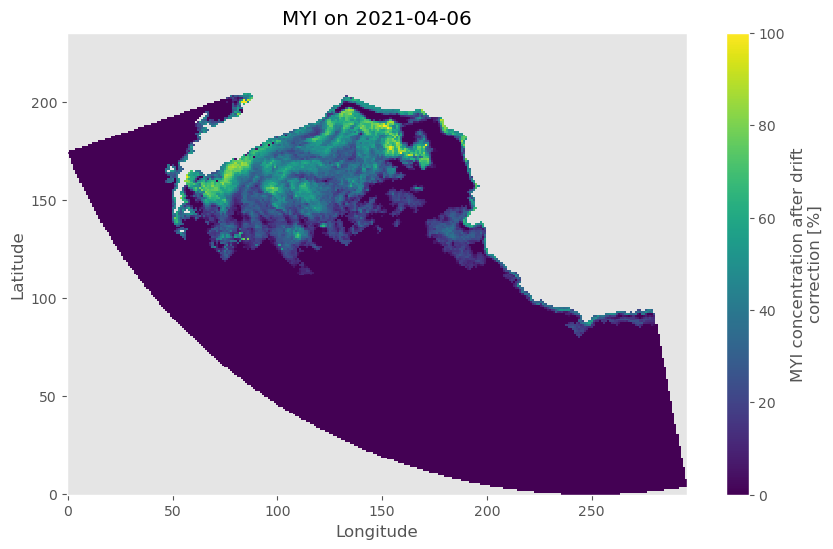

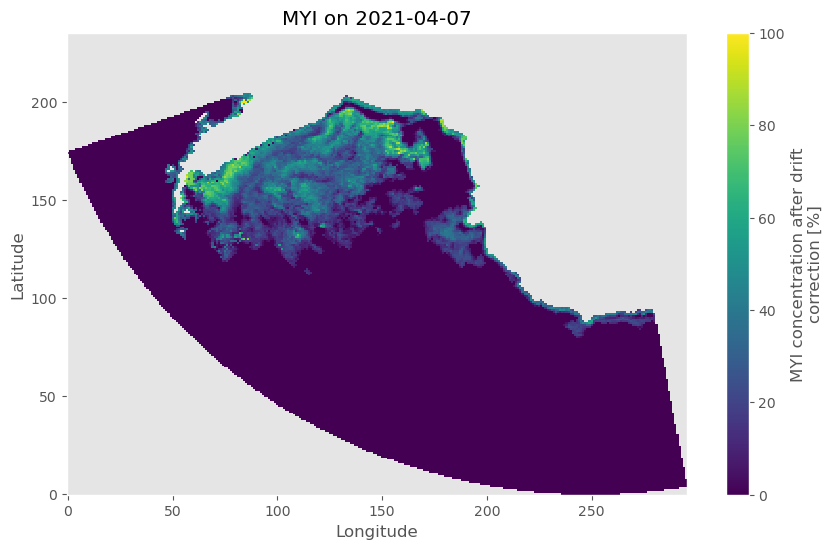

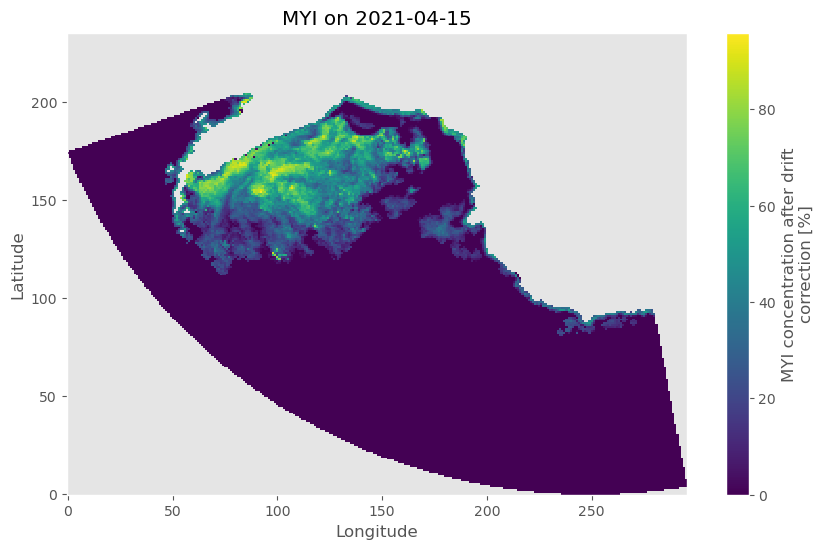

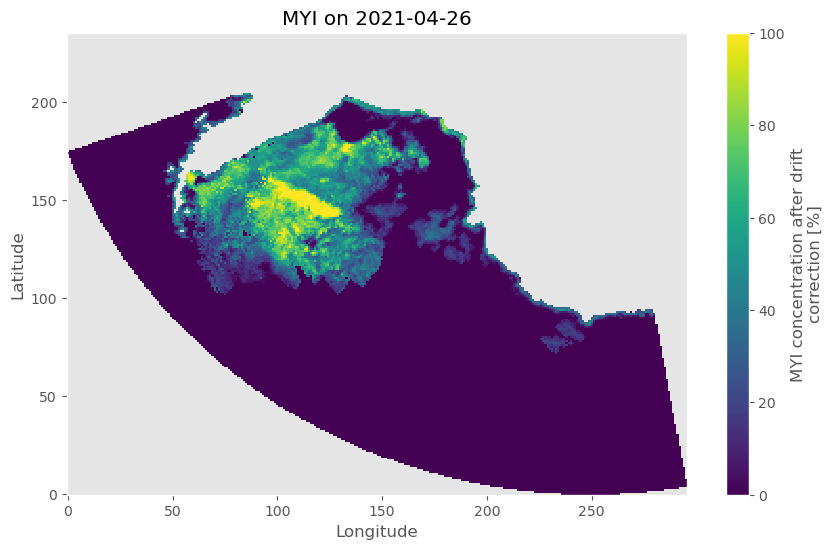

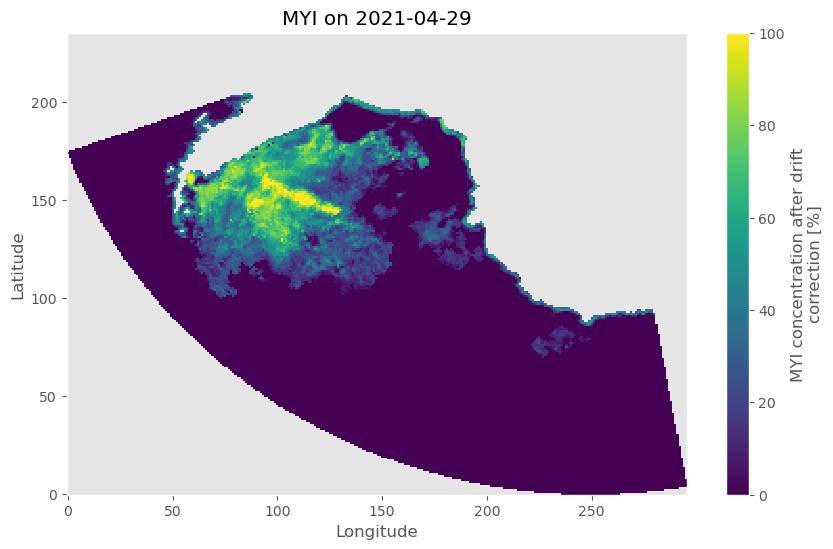

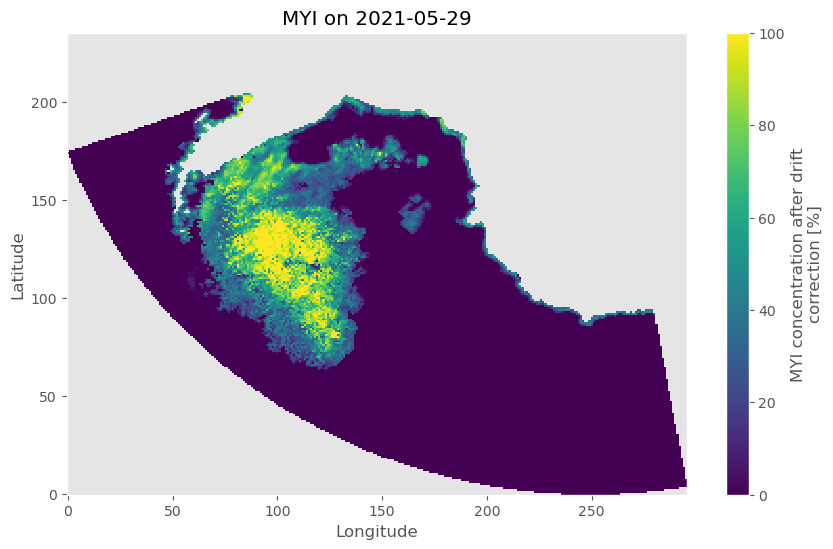

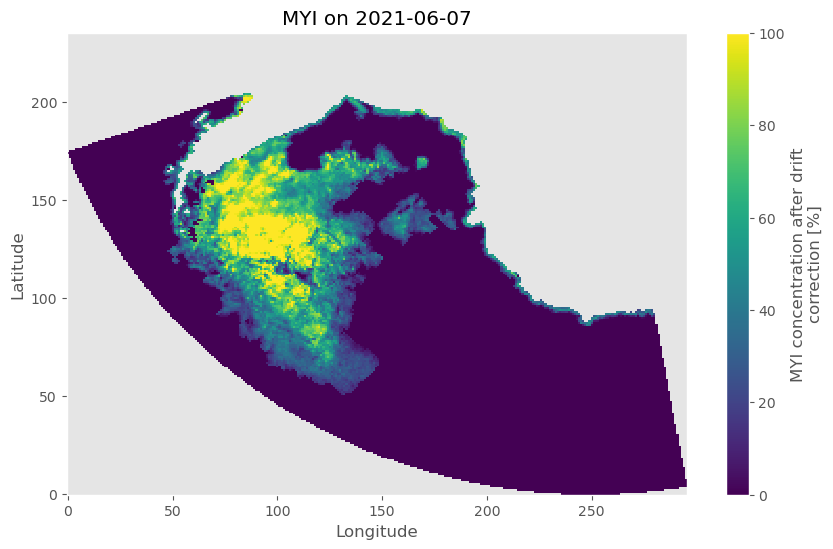

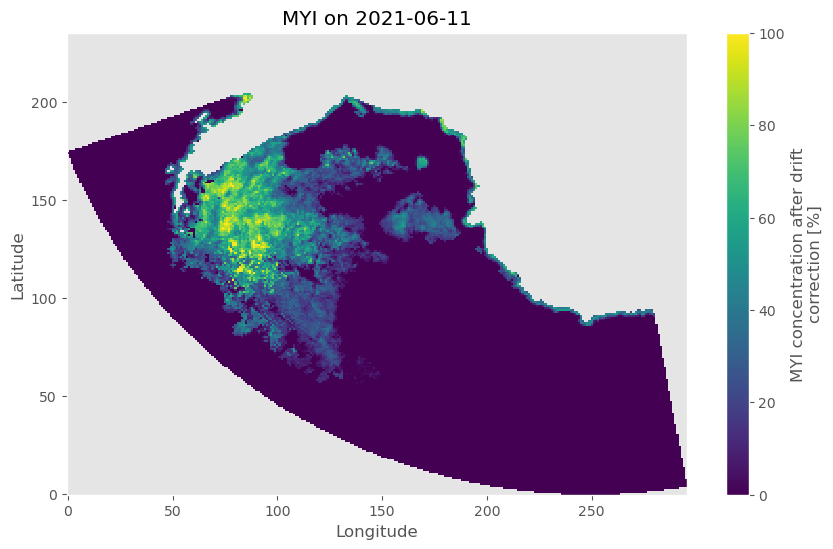

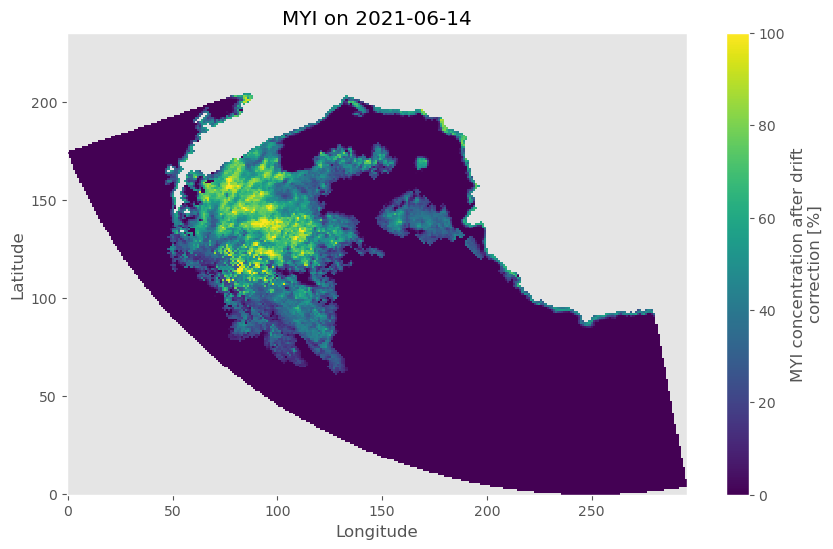

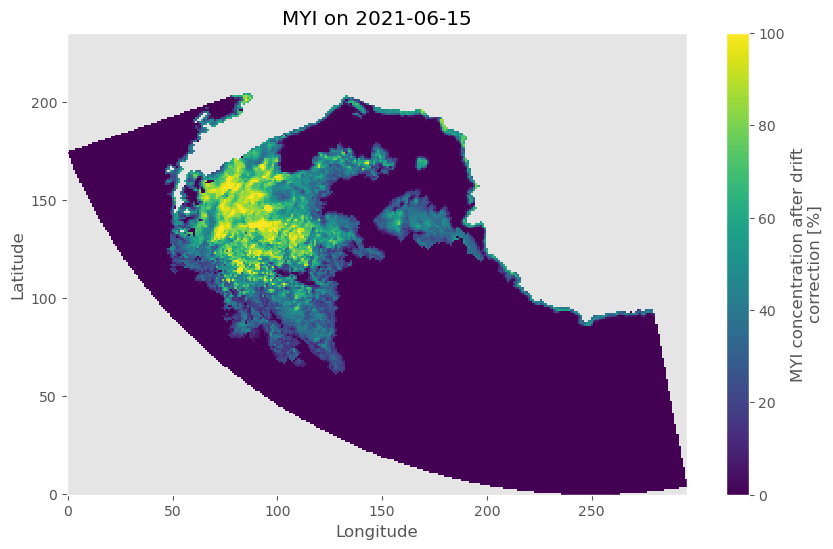

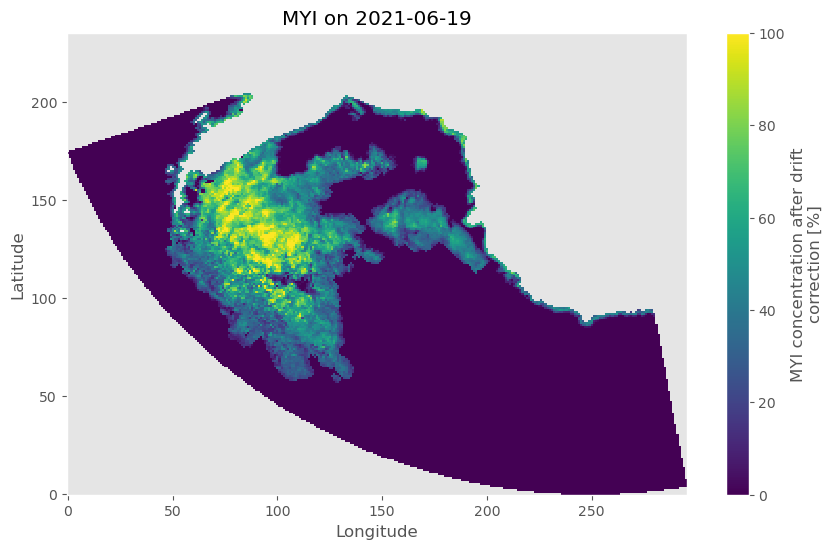

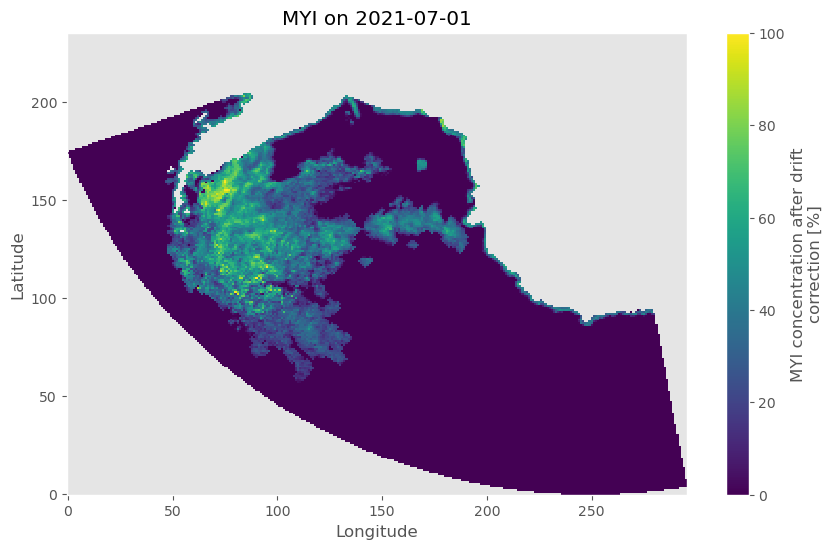

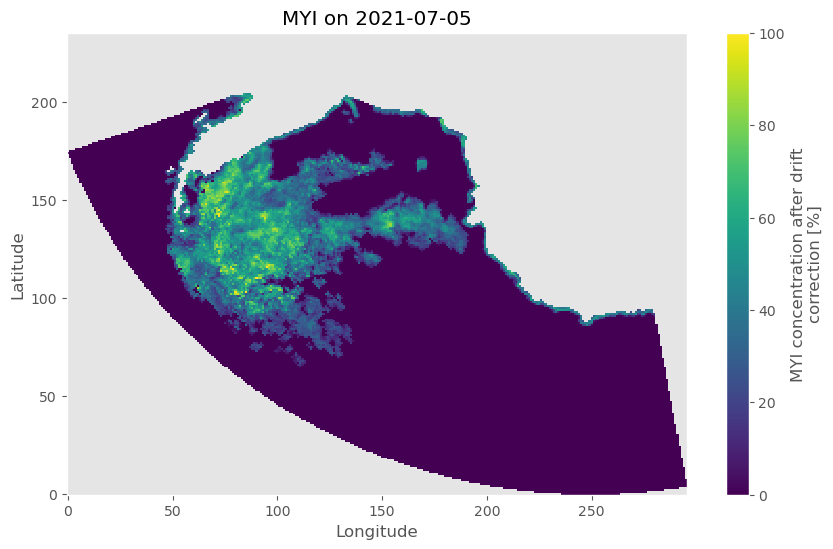

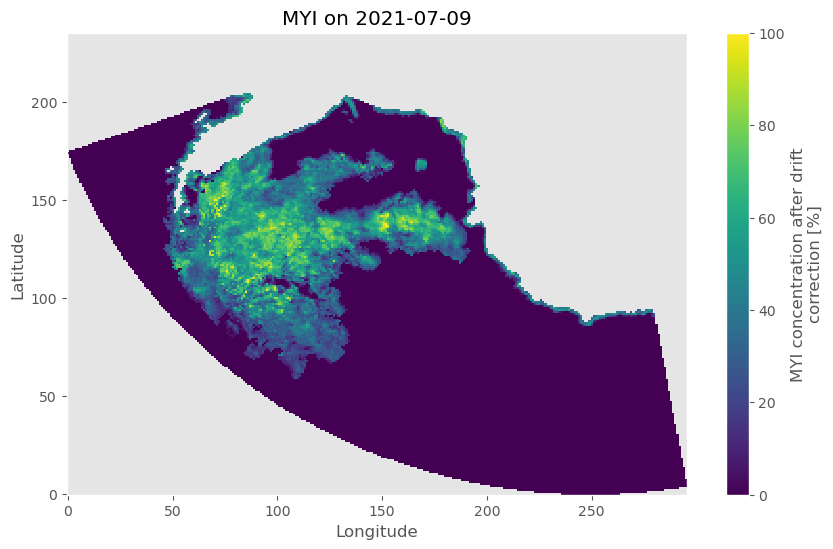

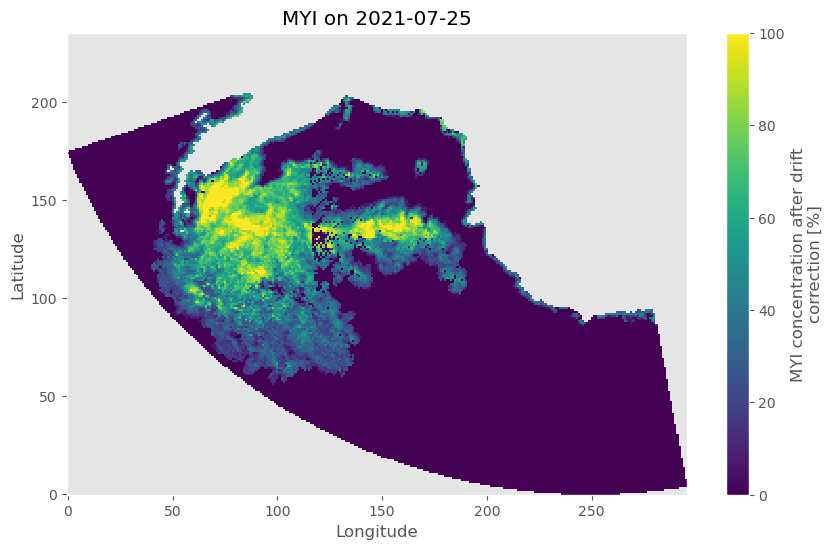

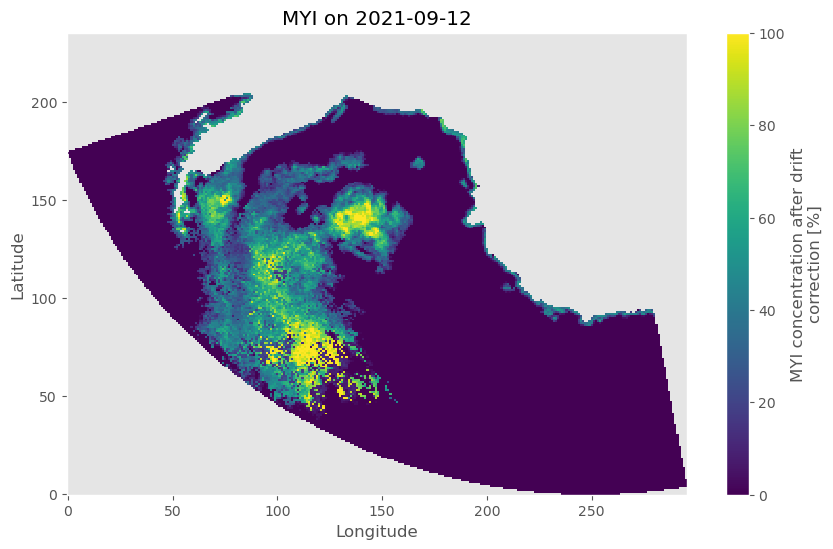

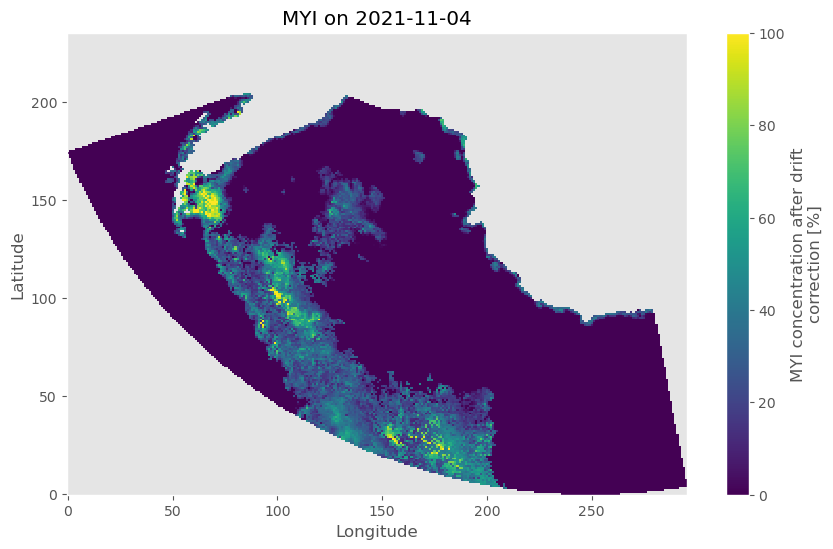

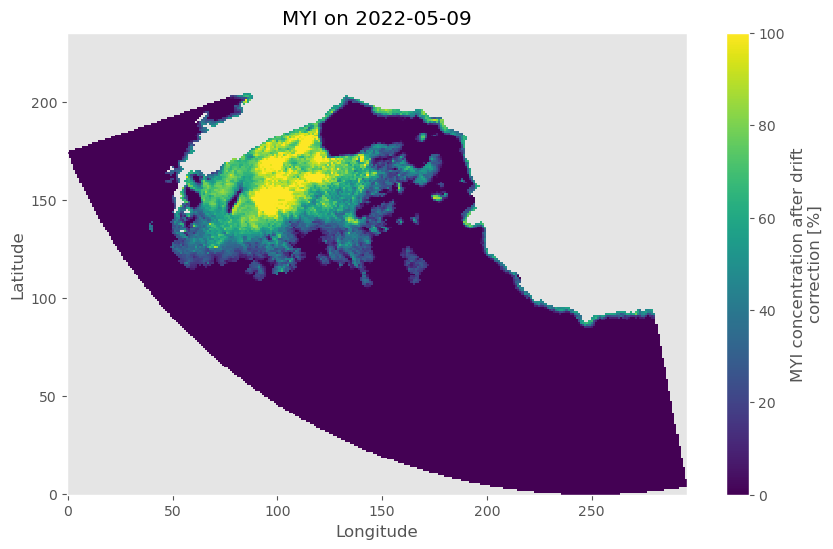

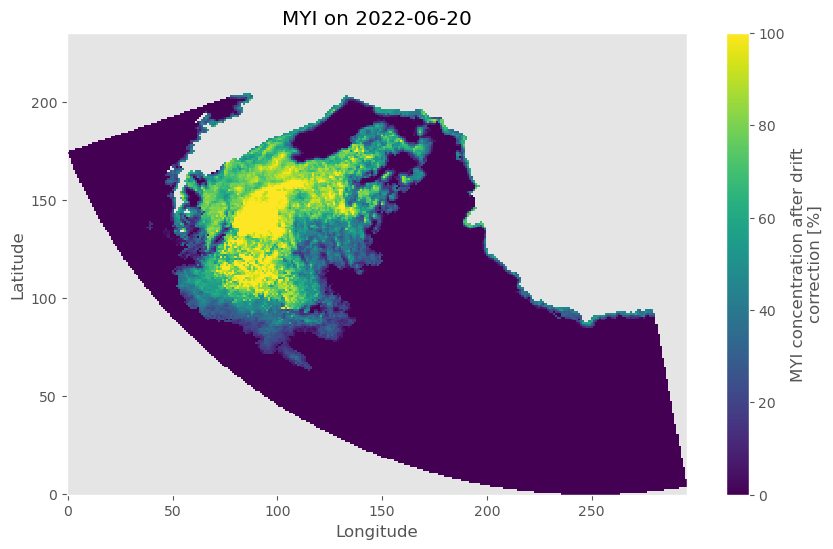

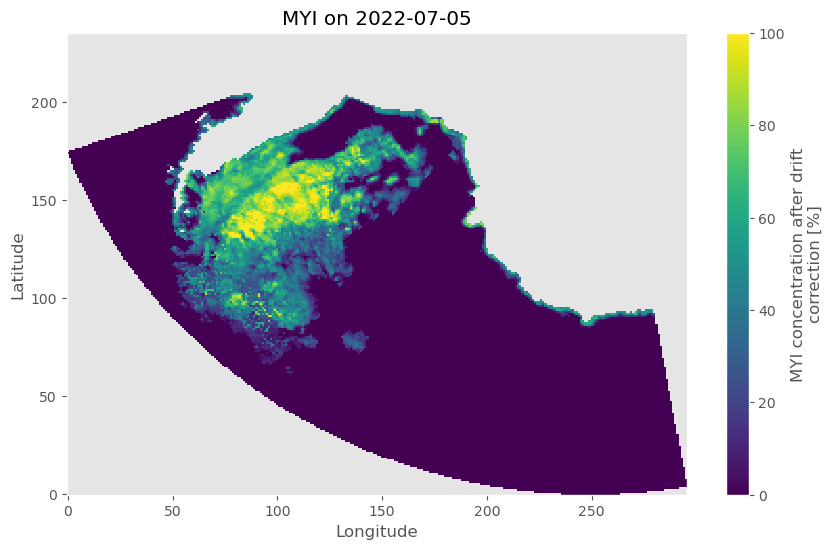

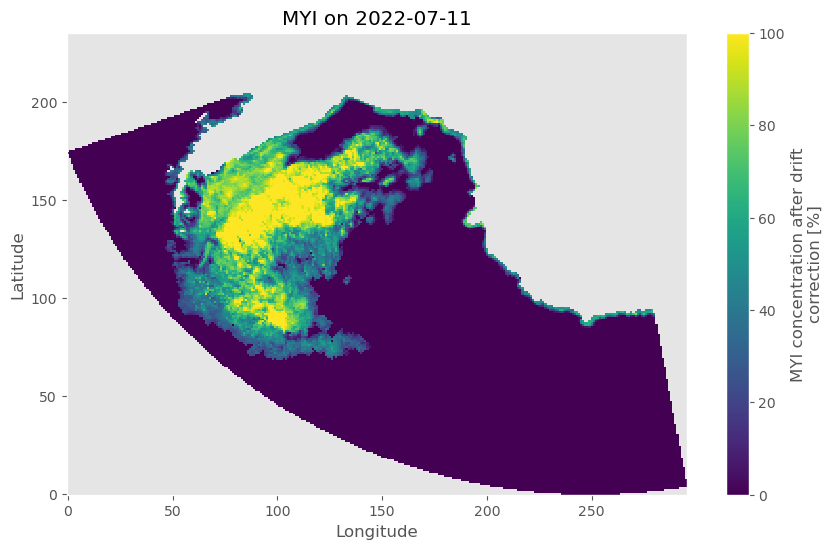

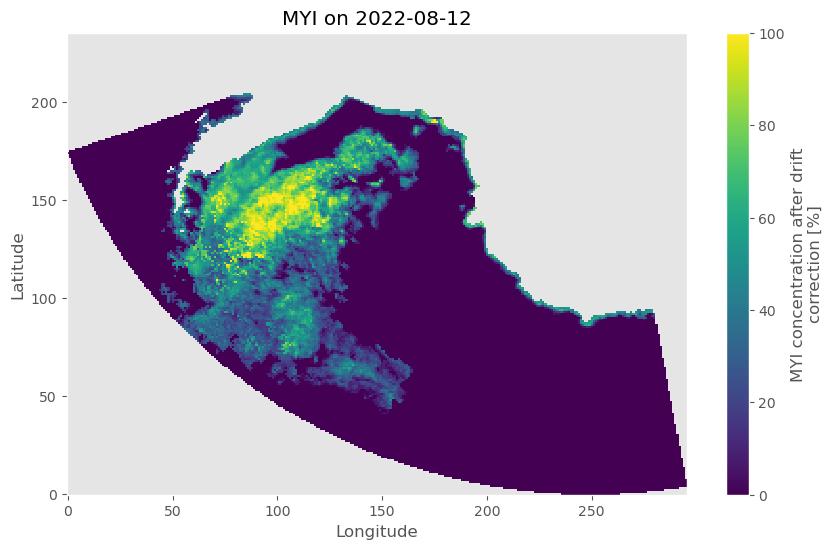

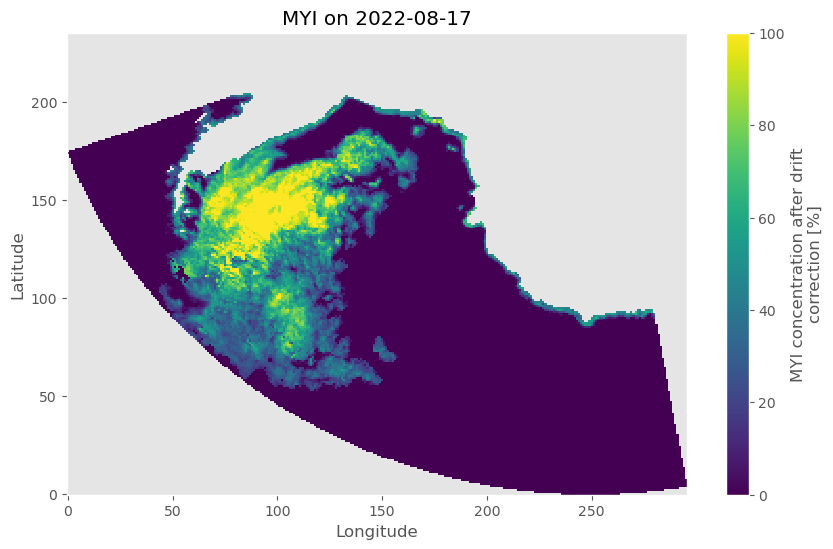

In [5]:
#plot MYI for all days in 29 matches
for i in range(len(subset_ds.time)):
    plt.figure(figsize=(10, 6))
    subset_ds["MYI"].isel(time=i).plot(cmap="viridis")
    plt.title(f"MYI on {str(subset_ds['time'].values[i])[:10]}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

<div class="alert alert-info" role="alert">

## <a id="section2"></a>29 Matches: Load Data 
[Back to top](#TOC_TOP)

</div>

In [6]:
file = "matches_2019.txt"
ds_2019 = pd.read_csv(file, sep=None, engine="python") 

In [7]:
file = "matches_2021.txt"
ds_2021 = pd.read_csv(file, sep=None, engine="python") 

In [8]:
file = "matches_2022.txt"
ds_2022 = pd.read_csv(file, sep=None, engine="python") 

In [9]:
matches_all = pd.concat([ds_2019, ds_2021, ds_2022])
merged_df = matches_all.reset_index(drop=True)
merged_df

,Year,Month,Day,X,Y,Snow_depth_satellite,Snow_depth_buoy,Mean_snow_accu,X_buoy,Y_buoy,Sensor_Number,lat_buoy,lon_buoy,lat_Kako20,lon_Kako20,Timestamp
0,2019,5,6,-850.0,1550.0,11.35041,69.652,106.428,-852.700889,1548.047796,S56,-73.7900,-28.8470,-73.78629,-28.73980,2019-05-06
1,2019,5,22,-900.0,1425.0,23.25146,69.014,105.882,-911.347875,1433.840884,S56,-74.4098,-32.4400,-74.53261,-32.27565,2019-05-22
2,2019,6,23,-1100.0,1425.0,29.40812,68.443,105.311,-1101.271050,1432.386386,S56,-73.4330,-37.5544,-73.49296,-37.66562,2019-06-23
3,2019,9,9,-1400.0,1650.0,24.64406,69.910,107.286,-1395.346692,1660.871508,S56,-70.1682,-40.0346,-70.21578,-40.31410,2019-09-09
4,2019,10,5,-1450.0,1775.0,29.25603,72.372,109.749,-1450.425563,1771.493331,S56,-69.0910,-39.3092,-69.06914,-39.24543,2019-10-05
5,2021,4,1,-950.0,1250.0,4.23426,56.272,56.272,-947.114309,1257.867750,S114,-75.5392,-36.9780,-75.58042,-37.23483,2021-04-01
6,2021,4,2,-875.0,1450.0,2.67530,27.575,27.575,-875.433826,1450.742312,S112,-74.4510,-31.1084,-74.45880,-31.10881,2021-04-02
7,2021,4,6,-950.0,1300.0,5.77390,56.108,56.108,-951.990407,1303.353240,S114,-75.1808,-36.1450,-75.21606,-36.15818,2021-04-06
8,2021,4,7,-800.0,1550.0,19.25122,71.266,110.243,-802.774653,1560.944791,S55,-73.8994,-27.2162,-73.99904,-27.29957,2021-04-07
9,2021,4,15,-875.0,1450.0,4.44346,23.484,27.45,-879.643312,1441.222830,S112,-74.5050,-31.3976,-74.45880,-31.10881,2021-04-15


<div class="alert alert-info" role="alert">

## <a id="section3"></a>Extract the 2x2 Box of Multiyear Ice Concentration for each Match 
[Back to top](#TOC_TOP)

</div>

In [10]:
results = []

# Iterate through each row in merged_df
for idx, row in merged_df.iterrows():
    time_point = pd.to_datetime(row["Timestamp"])  
    lat_point = row["lat_Kako20"]
    lon_point = row["lon_Kako20"]

    # Select the nearest time point from the dataset
    ds_time = subset_ds.sel(time=time_point, method="nearest")

    # Prepare points and values for KDTree
    points = np.column_stack((ds_time["lat"].values.ravel(), ds_time["lon"].values.ravel()))
    values = ds_time["MYI"].values.ravel()

    # Create a KDTree for efficient nearest neighbor search
    tree = cKDTree(points)

    # Find the indices of the 4 nearest neighbors
    distances, indices = tree.query([lat_point, lon_point], k=4)

    # Extract the nearest points and corresponding MYI values
    nearest_points = points[indices]
    nearest_values = values[indices]

    # Calculate the average MYI value
    myi_value = np.mean(nearest_values)

    # Append the results to the list
    results.append({
        "Timestamp": time_point,
        "lat_point": lat_point,
        "lon_point": lon_point,
        "Average_MYI": myi_value,
        "Nearest_Points": nearest_points.tolist(),
        "Nearest_Values": nearest_values.tolist()
    })

results_df = pd.DataFrame(results)
results_df

C:\Users\Kirsten\miniconda3\envs\tutorial\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


,Timestamp,lat_point,lon_point,Average_MYI,Nearest_Points,Nearest_Values
0,2019-05-06,-73.78629,-28.73980,25.500000,"[[-73.70945, -28.81963], [-73.86311, -28.65919...","[29.5, 22.0, 27.100000381469727, 23.3999996185..."
1,2019-05-22,-74.53261,-32.27565,32.724998,"[[-74.4544, -32.34149], [-74.61081, -32.20912]...","[35.5, 26.899999618530273, 47.0, 21.5]"
2,2019-06-23,-73.49296,-37.66562,41.275002,"[[-73.41364, -37.70136], [-73.57229, -37.62953...","[46.400001525878906, 37.70000076293945, 47.299..."
3,2019-09-09,-70.21578,-40.31410,48.174999,"[[-70.13677, -40.33314], [-70.2948, -40.2949],...","[60.29999923706055, 41.900001525878906, 50.5, ..."
4,2019-10-05,-69.06914,-39.24543,44.200001,"[[-68.99055, -39.2675], [-69.14776, -39.22319]...","[48.70000076293945, 38.70000076293945, 37.7000..."
5,2021-04-01,-75.58042,-37.23483,0.000000,"[[-75.5008, -37.27817], [-75.66004, -37.19101]...","[0.0, 0.0, 0.0, 0.0]"
6,2021-04-02,-74.45880,-31.10881,0.000000,"[[-74.38098, -31.18024], [-74.53661, -31.03665...","[0.0, 0.0, 0.0, 0.0]"
7,2021-04-06,-75.21606,-36.15818,0.000000,"[[-75.13672, -36.20627], [-75.2954, -36.10958]...","[0.0, 0.0, 0.0, 0.0]"
8,2021-04-07,-73.99904,-27.29957,25.550001,"[[-73.92275, -27.38742], [-74.07531, -27.21087...","[31.200000762939453, 23.299999237060547, 35.79..."
9,2021-04-15,-74.45880,-31.10881,0.000000,"[[-74.38098, -31.18024], [-74.53661, -31.03665...","[0.0, 0.0, 0.0, 0.0]"


In [11]:
merged_df["Average_MYI"] = results_df["Average_MYI"]
matches_MYI= merged_df
matches_MYI
#matches_MYI.to_csv("matches_MYI.csv", index=False)

,Year,Month,Day,X,Y,Snow_depth_satellite,Snow_depth_buoy,Mean_snow_accu,X_buoy,Y_buoy,Sensor_Number,lat_buoy,lon_buoy,lat_Kako20,lon_Kako20,Timestamp,Average_MYI
0,2019,5,6,-850.0,1550.0,11.35041,69.652,106.428,-852.700889,1548.047796,S56,-73.7900,-28.8470,-73.78629,-28.73980,2019-05-06,25.500000
1,2019,5,22,-900.0,1425.0,23.25146,69.014,105.882,-911.347875,1433.840884,S56,-74.4098,-32.4400,-74.53261,-32.27565,2019-05-22,32.724998
2,2019,6,23,-1100.0,1425.0,29.40812,68.443,105.311,-1101.271050,1432.386386,S56,-73.4330,-37.5544,-73.49296,-37.66562,2019-06-23,41.275002
3,2019,9,9,-1400.0,1650.0,24.64406,69.910,107.286,-1395.346692,1660.871508,S56,-70.1682,-40.0346,-70.21578,-40.31410,2019-09-09,48.174999
4,2019,10,5,-1450.0,1775.0,29.25603,72.372,109.749,-1450.425563,1771.493331,S56,-69.0910,-39.3092,-69.06914,-39.24543,2019-10-05,44.200001
5,2021,4,1,-950.0,1250.0,4.23426,56.272,56.272,-947.114309,1257.867750,S114,-75.5392,-36.9780,-75.58042,-37.23483,2021-04-01,0.000000
6,2021,4,2,-875.0,1450.0,2.67530,27.575,27.575,-875.433826,1450.742312,S112,-74.4510,-31.1084,-74.45880,-31.10881,2021-04-02,0.000000
7,2021,4,6,-950.0,1300.0,5.77390,56.108,56.108,-951.990407,1303.353240,S114,-75.1808,-36.1450,-75.21606,-36.15818,2021-04-06,0.000000
8,2021,4,7,-800.0,1550.0,19.25122,71.266,110.243,-802.774653,1560.944791,S55,-73.8994,-27.2162,-73.99904,-27.29957,2021-04-07,25.550001
9,2021,4,15,-875.0,1450.0,4.44346,23.484,27.45,-879.643312,1441.222830,S112,-74.5050,-31.3976,-74.45880,-31.10881,2021-04-15,0.000000


<div class="alert alert-info" role="alert">

## <a id="section4"></a>Analysis of Multiyear Ice Concentration Dependency
[Back to top](#TOC_TOP)

</div>

<div class="alert alert-danger" role="alert">

### <a id="section4.1"></a>Map of Multiyear Ice Concentration for 27 Matches
[Back to top](#TOC_TOP)

</div>

In [12]:
matches_MYI = matches_MYI[matches_MYI["Sensor_Number"] != "S112"]
matches_MYI = matches_MYI.reset_index(drop=True)
matches_MYI

,Year,Month,Day,X,Y,Snow_depth_satellite,Snow_depth_buoy,Mean_snow_accu,X_buoy,Y_buoy,Sensor_Number,lat_buoy,lon_buoy,lat_Kako20,lon_Kako20,Timestamp,Average_MYI
0,2019,5,6,-850.0,1550.0,11.35041,69.652,106.428,-852.700889,1548.047796,S56,-73.7900,-28.8470,-73.78629,-28.73980,2019-05-06,25.500000
1,2019,5,22,-900.0,1425.0,23.25146,69.014,105.882,-911.347875,1433.840884,S56,-74.4098,-32.4400,-74.53261,-32.27565,2019-05-22,32.724998
2,2019,6,23,-1100.0,1425.0,29.40812,68.443,105.311,-1101.271050,1432.386386,S56,-73.4330,-37.5544,-73.49296,-37.66562,2019-06-23,41.275002
3,2019,9,9,-1400.0,1650.0,24.64406,69.910,107.286,-1395.346692,1660.871508,S56,-70.1682,-40.0346,-70.21578,-40.31410,2019-09-09,48.174999
4,2019,10,5,-1450.0,1775.0,29.25603,72.372,109.749,-1450.425563,1771.493331,S56,-69.0910,-39.3092,-69.06914,-39.24543,2019-10-05,44.200001
5,2021,4,1,-950.0,1250.0,4.23426,56.272,56.272,-947.114309,1257.867750,S114,-75.5392,-36.9780,-75.58042,-37.23483,2021-04-01,0.000000
6,2021,4,6,-950.0,1300.0,5.77390,56.108,56.108,-951.990407,1303.353240,S114,-75.1808,-36.1450,-75.21606,-36.15818,2021-04-06,0.000000
7,2021,4,7,-800.0,1550.0,19.25122,71.266,110.243,-802.774653,1560.944791,S55,-73.8994,-27.2162,-73.99904,-27.29957,2021-04-07,25.550001
8,2021,4,26,-1000.0,1350.0,10.00154,56.343,58.800,-994.425999,1344.370448,S114,-74.6526,-36.4902,-74.58146,-36.52886,2021-04-26,0.000000
9,2021,5,29,-1100.0,1300.0,14.09222,59.694,63.765,-1090.551176,1311.021846,S114,-74.3522,-39.7548,-74.37370,-40.23636,2021-05-29,0.000000


C:\Users\Kirsten\AppData\Local\Temp\ipykernel_77804\3756391695.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scatter, location="right", label="Sea ice concentration [%]")


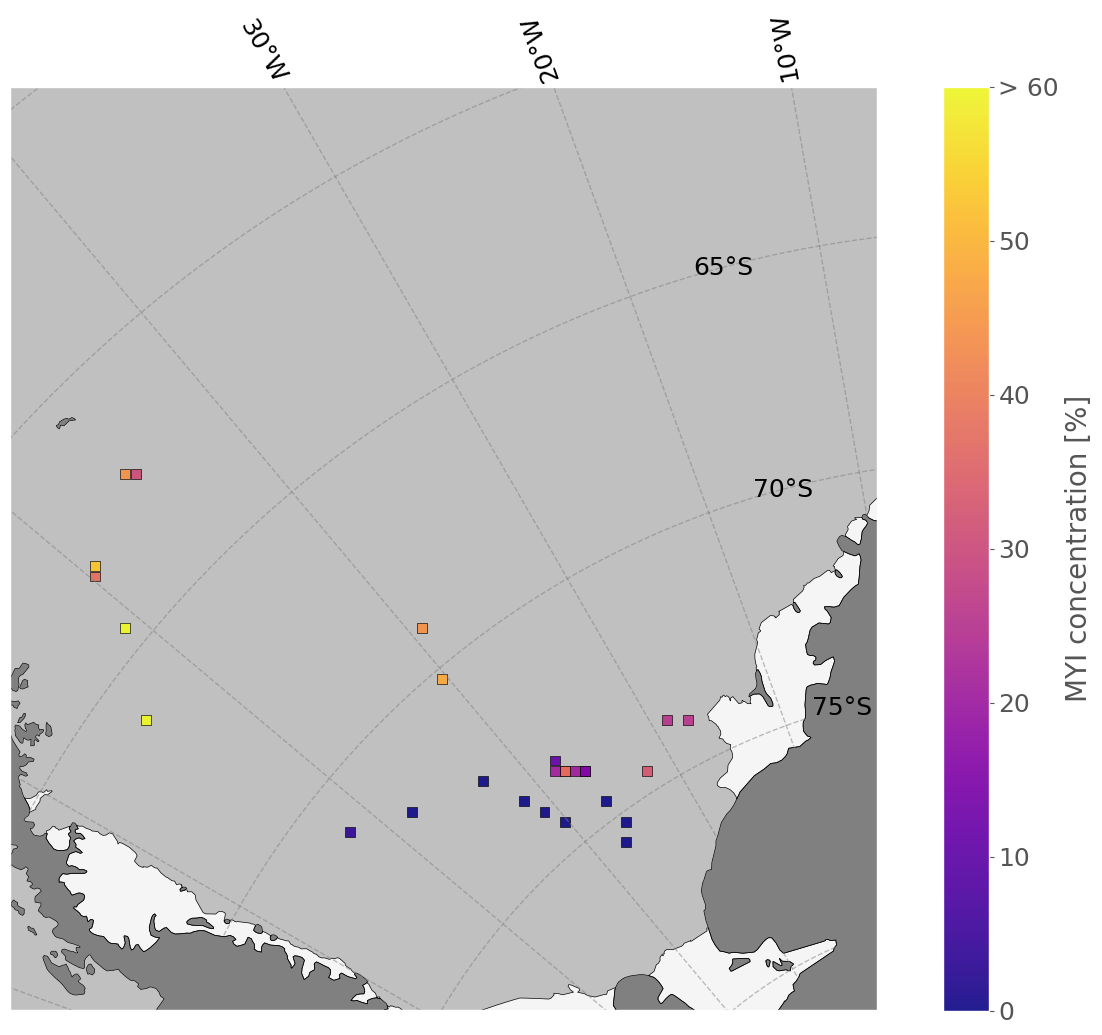

In [13]:
fig, ax = plt.subplots(figsize=(17, 12), subplot_kw={"projection": ccrs.SouthPolarStereo()})

sensor_groups = matches_MYI.groupby("Sensor_Number")

scatter = (plt.scatter(matches_MYI["lon_Kako20"], matches_MYI["lat_Kako20"], c=matches_MYI["Average_MYI"],  marker="s", 
                       cmap="plasma", s=50, edgecolor="k", alpha=0.9, transform=ccrs.PlateCarree(), vmin=0, vmax=60))

cbar = plt.colorbar(scatter, location="right", label="Sea ice concentration [%]")
cbar.set_label("MYI concentration [%]", fontsize=20)

cbar_ticks = np.linspace(0, 60, num=7)
cbar_ticklabels = [str(int(tick)) for tick in cbar_ticks]
cbar_ticklabels[-1] = "> 60"

cbar.ax.tick_params(labelsize=18)
cbar.set_ticks(cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticklabels)


# Weddell Sea region
extent = [-50, -15, -78, -61]
ax.set_extent(extent, crs=ccrs.PlateCarree())


# Add natural features
Ice_shelves = cfeature.NaturalEarthFeature(
    category="physical",
    name="antarctic_ice_shelves_polys",
    scale="50m"
)

ax.add_feature(cfeature.LAND.with_scale("50m"), facecolor="grey")
ax.add_feature(cfeature.OCEAN, facecolor="silver")
ax.add_feature(Ice_shelves, facecolor="whitesmoke", edgecolor="black")

ax.coastlines()


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color="gray", alpha=0.5, linestyle="--")
gl.top_labels = True  
gl.right_labels = True  
gl.left_labels = True 
gl.bottom_labels = False  
gl.xlabel_style = {"size": 18}
gl.ylabel_style = {"size": 18}

plt.show()

## Add Snow Buoy trajectories

In [14]:
file = "ds_buoys_27.csv"
ds = pd.read_csv(file, sep=None, engine="python") 

ds["timestamp"] = pd.to_datetime(ds["timestamp"], errors="coerce")

# List of months
months = [4, 5, 6, 7, 8, 9, 10, 11]

# Filter for the specified months
filtered_ds_months = ds[ds["Month"].isin(months)]

# List of years
years = [2019, 2020, 2021, 2022]

# Iterate over years
for year in years:
    # Filter for the years
    filtered_ds = filtered_ds_months[filtered_ds_months["Year"] == year]
    
    if year == 2019:
        ds_2019 = filtered_ds
    elif year == 2020:
        ds_2020 = filtered_ds
    elif year == 2021:
        ds_2021 = filtered_ds
    elif year == 2022:
        ds_2022 = filtered_ds

#no snow data in july 7 month in satellite product
ds_2019 = ds_2019[ds_2019["Month"] != 7]

#no snow data in Oct and Nov in satellite product
ds_2022 = ds_2022[ds_2022["Month"] != 10]
ds_2022 = ds_2022[ds_2022["Month"] != 11]

ds_S114 = ds_2021[ds_2021["Sensor Number"] == "S114"] #custom_palette[8]
ds_S114_2022 = ds_2022[ds_2022["Sensor Number"] == "S114"] #custom_palette[8]
ds_S112 = ds_2021[ds_2021["Sensor Number"] == "S112"] #custom_palette[5]
ds_S55 = ds_2021[ds_2021["Sensor Number"] == "S55"]  #custom_palette[2]
ds_S56 = ds_2019[ds_2019["Sensor Number"] == "S56"] #custom_palette[0]

C:\Users\Kirsten\AppData\Local\Temp\ipykernel_77804\3838835202.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scatter, location="right", label="Sea ice concentration [%]")


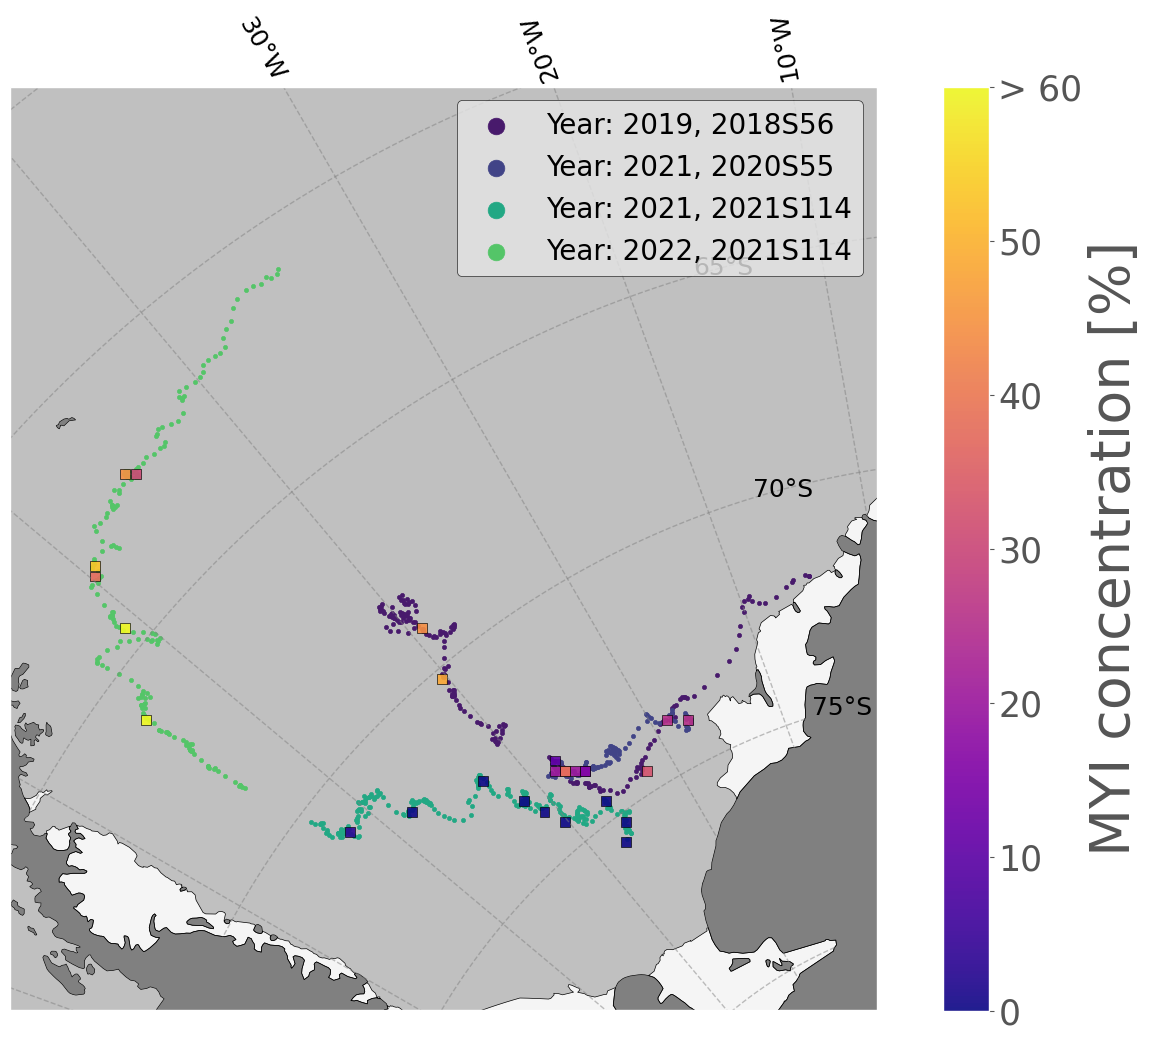

In [15]:
fig, ax = plt.subplots(figsize=(17, 12), subplot_kw={"projection": ccrs.SouthPolarStereo()})

sensor_groups = matches_MYI.groupby("Sensor_Number")

custom_palette = sns.color_palette("viridis", 14) 


scatters = ax.scatter(ds_S56["Longitude"], ds_S56["Latitude"], transform=ccrs.PlateCarree(), 
                       marker=".", 
                       color=custom_palette[0], label="Year: 2019, 2018S56")


#Snow Buoy
scatters = ax.scatter(ds_S55["Longitude"], ds_S55["Latitude"], transform=ccrs.PlateCarree(), 
                       marker=".", 
                       color=custom_palette[2], label="Year: 2021, 2020S55")


scatters = ax.scatter(ds_S114["Longitude"], ds_S114["Latitude"], transform=ccrs.PlateCarree(), 
                       marker=".", 
                       color=custom_palette[8], label="Year: 2021, 2021S114")


scatters = ax.scatter(ds_S114_2022["Longitude"], ds_S114_2022["Latitude"], transform=ccrs.PlateCarree(), 
                       marker=".", 
                       color=custom_palette[10], label="Year: 2022, 2021S114")

#MYI Concentration
scatter = (plt.scatter(matches_MYI["lon_Kako20"], matches_MYI["lat_Kako20"], c=matches_MYI["Average_MYI"],  marker="s", 
                       cmap="plasma", s=50, edgecolor="k", alpha=0.9, transform=ccrs.PlateCarree(), vmin=0, vmax=60))

cbar = plt.colorbar(scatter, location="right", label="Sea ice concentration [%]")
cbar.set_label("MYI concentration [%]", fontsize=40)

cbar_ticks = np.linspace(0, 60, num=7)
cbar_ticklabels = [str(int(tick)) for tick in cbar_ticks]
cbar_ticklabels[-1] = "> 60"

cbar.ax.tick_params(labelsize=25)
cbar.set_ticks(cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticklabels)


# Weddell Sea region
extent = [-50, -15, -78, -61]
ax.set_extent(extent, crs=ccrs.PlateCarree())



# Add natural features
Ice_shelves = cfeature.NaturalEarthFeature(
    category="physical",
    name="antarctic_ice_shelves_polys",
    scale="50m"
)

ax.add_feature(cfeature.LAND.with_scale("50m"), facecolor="grey")
ax.add_feature(cfeature.OCEAN, facecolor="silver")
ax.add_feature(Ice_shelves, facecolor="whitesmoke", edgecolor="black")

ax.coastlines()



plt.legend(loc="upper right",edgecolor="black", prop={"size": 20}, markerscale=4)



gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color="gray", alpha=0.5, linestyle="--")
gl.top_labels = True  
gl.right_labels = True  
gl.left_labels = True  
gl.bottom_labels = False  
gl.xlabel_style = {"size": 18}
gl.ylabel_style = {"size": 18}

plt.savefig("MYI_location02.png", bbox_inches="tight", dpi=300)
plt.show()

<div class="alert alert-danger" role="alert" >
    

### <a id="section4.2"></a>Histogram of MYI Concentration
[Back to top](#TOC_TOP)

</div>

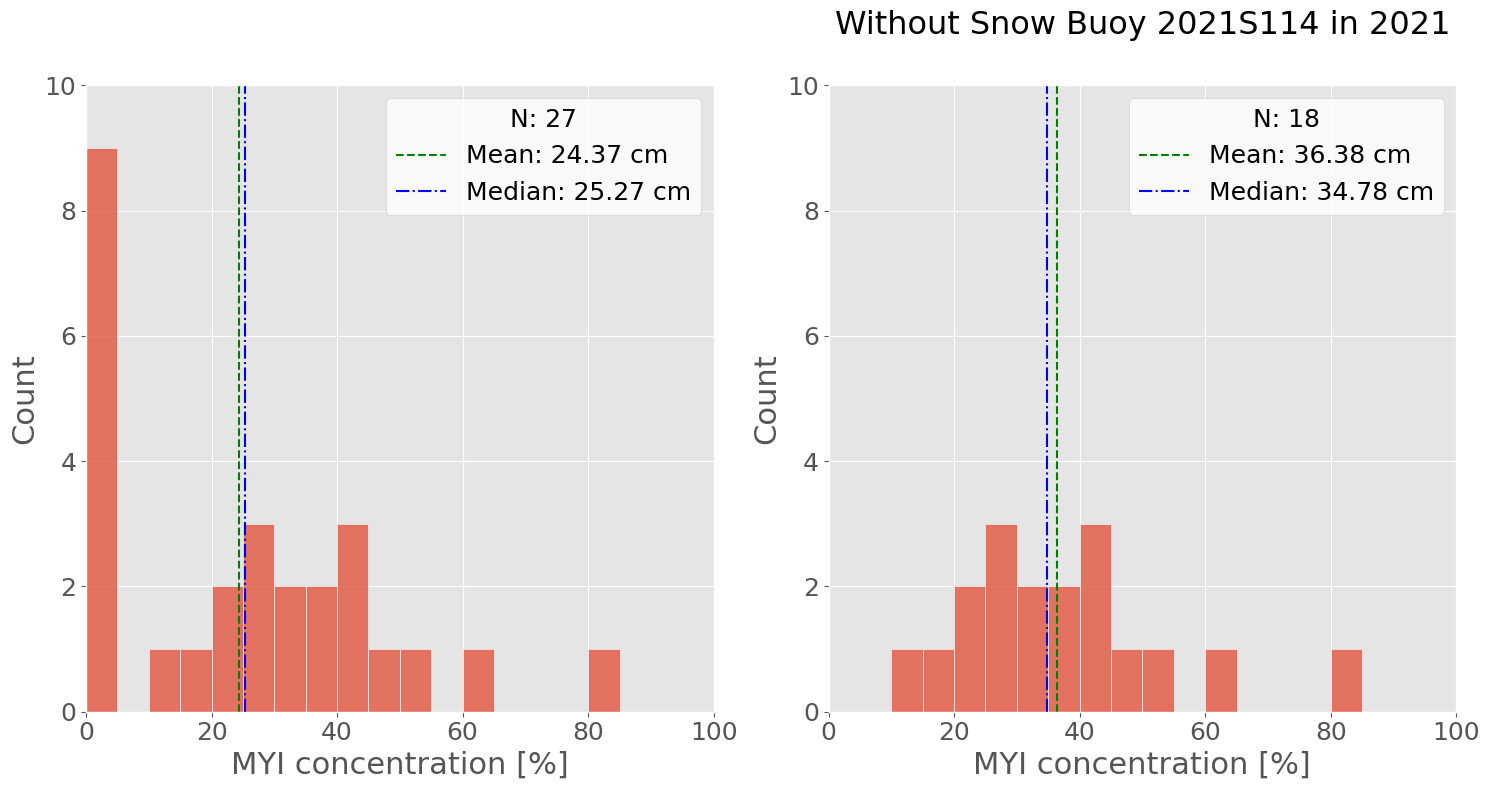

In [16]:
MYI = matches_MYI[matches_MYI["Sensor_Number"] != "S112"]["Average_MYI"]
SampleMean_MYI = np.nanmean(MYI)
SampleMedian_MYI = np.nanmedian(MYI)

MYI02 = matches_MYI[~((matches_MYI["Sensor_Number"] == "S114") & (matches_MYI["Year"] == 2021))]["Average_MYI"]

SampleMean_MYI02 = np.nanmean(MYI02)
SampleMedian_MYI02 = np.nanmedian(MYI02)

N_MYI = len(MYI)
N_MYI02 = len(MYI02)

fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Define font size
title_fontsize = 23
label_fontsize = 22
linespacing = 1.5

# Set the axis limits
x_limits = (0, 100)
y_limits = (0, 10)

# Define bin width and calculate the number of bins
bin_width = 5
bins = np.arange(x_limits[0], x_limits[1] + bin_width, bin_width)

sns.histplot(MYI, kde=False, stat="count", bins=bins, ax=axs[0])
axs[0].axvline(SampleMean_MYI, color="green", linestyle="--", label="Mean: {:.2f} cm".format(SampleMean_MYI))
axs[0].axvline(SampleMedian_MYI, color="blue", linestyle="-.", label="Median: {:.2f} cm".format(SampleMedian_MYI))
axs[0].set_xlabel("MYI concentration [%]", fontsize=label_fontsize)
axs[0].set_ylabel("Count", fontsize=label_fontsize)
axs[0].set_xlim(x_limits)
axs[0].set_ylim(y_limits)
axs[0].tick_params(axis="x", labelsize=18)
axs[0].tick_params(axis="y", labelsize=18)
axs[0].legend(title=f"N: {N_MYI}", title_fontsize=18, fontsize=18, facecolor="white")

sns.histplot(MYI02, kde=False, stat="count", bins=bins, ax=axs[1])
axs[1].set_title("Without Snow Buoy 2021S114 in 2021\n", fontsize=title_fontsize, linespacing=linespacing)
axs[1].axvline(SampleMean_MYI02, color="green", linestyle="--", label="Mean: {:.2f} cm".format(SampleMean_MYI02))
axs[1].axvline(SampleMedian_MYI02, color="blue", linestyle="-.", label="Median: {:.2f} cm".format(SampleMedian_MYI02))
axs[1].set_xlabel("MYI concentration [%]", fontsize=label_fontsize)
axs[1].set_ylabel("Count", fontsize=label_fontsize)
axs[1].set_xlim(x_limits)
axs[1].set_ylim(y_limits)
axs[1].tick_params(axis="x", labelsize=18)
axs[1].tick_params(axis="y", labelsize=18)
axs[1].legend(title=f"N: {N_MYI02}", title_fontsize=18, fontsize=18, facecolor="white")

plt.tight_layout()

plt.savefig("Histogram_MYI_02.png", dpi=300, bbox_inches="tight")

plt.show()

In [17]:
#.. perform Shapiro-Wilk test and print probability value
TestStat,ProbVal = shapiro(MYI)
print("* Shapiro-Wilk test, probability value   : {:.2e}\n".format(ProbVal))

* Shapiro-Wilk test, probability value   : 1.87e-02



In [18]:
#.. perform Shapiro-Wilk test and print probability value
TestStat,ProbVal = shapiro(MYI02) #w/o 2021S114 in 2021
print("* Shapiro-Wilk test, probability value   : {:.2e}\n".format(ProbVal))

* Shapiro-Wilk test, probability value   : 4.05e-01



<div class="alert alert-danger" role="alert" >
    

### <a id="section4.3"></a>Histogram of Snow Depth Differences
[Back to top](#TOC_TOP)

</div>

In [19]:
matches_MYI["Difference"] = matches_MYI["Snow_depth_buoy"] - matches_MYI["Snow_depth_satellite"]
ds_matches_29 = matches_MYI.copy()

In [20]:
sensor_number_mapping = {
    "S119": "2022S119",
    "S56": "2018S56",
    "S55": "2020S55",
    "S114": "2021S114",
    "S112": "2021S112"
}

# Update the Sensor_Number column in matches_all DataFrame
ds_matches_29["Sensor_Number"] = ds_matches_29["Sensor_Number"].map(sensor_number_mapping).fillna(ds_matches_29["Sensor_Number"])

In [21]:
Differences_wo_S112_data = ds_matches_29[ds_matches_29["Sensor_Number"] != "2021S112"]
Differences_wo_S112 = Differences_wo_S112_data["Difference"]


Differences_wo_S114_21_data = Differences_wo_S112_data[~((Differences_wo_S112_data["Sensor_Number"] == "2021S114") & (Differences_wo_S112_data["Year"] == 2021))]
Differences_wo_S114_21 = Differences_wo_S114_21_data["Difference"]


SampleMean_Differences_wo_S112 = np.nanmean(Differences_wo_S112)
SampleMean_Differences_wo_S114_21 = np.nanmean(Differences_wo_S114_21)

SampleMedian_Differences_wo_S112 = np.nanmedian(Differences_wo_S112)
SampleMedian_Differences_wo_S114_21 = np.nanmedian(Differences_wo_S114_21)

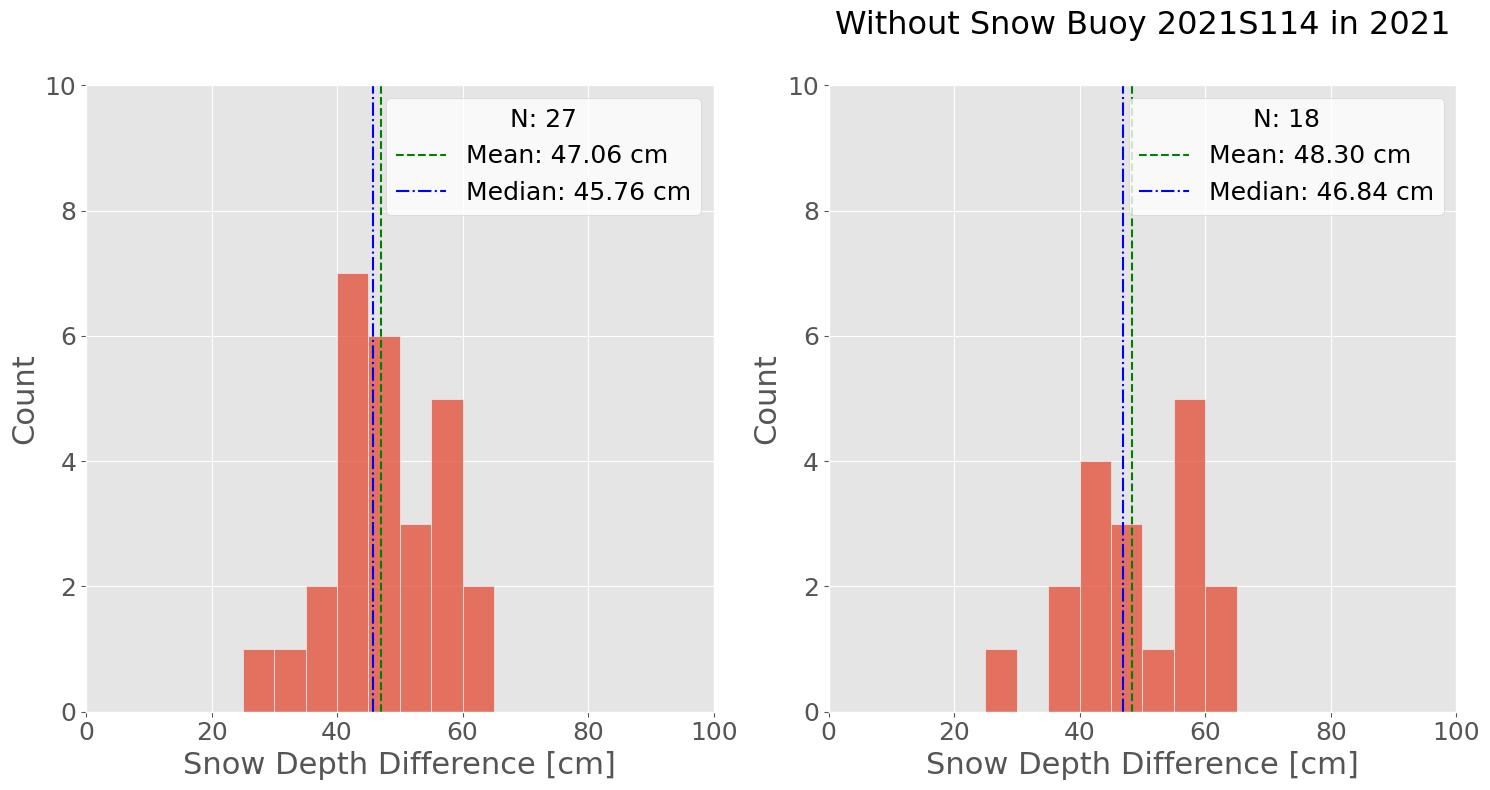

In [22]:
N_MYI = len(Differences_wo_S112)
N_MYI02 = len(Differences_wo_S114_21)

fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Define font size
title_fontsize = 23
label_fontsize = 22
linespacing = 1.5

# Set the axis limits
x_limits = (0, 100)
y_limits = (0, 10)

# Define bin width and calculate the number of bins
bin_width = 5
bins = np.arange(x_limits[0], x_limits[1] + bin_width, bin_width)

sns.histplot(Differences_wo_S112, kde=False, stat="count", bins=bins, ax=axs[0])
axs[0].axvline(SampleMean_Differences_wo_S112, color="green", linestyle="--", label="Mean: {:.2f} cm".format(SampleMean_Differences_wo_S112))
axs[0].axvline(SampleMedian_Differences_wo_S112, color="blue", linestyle="-.", label="Median: {:.2f} cm".format(SampleMedian_Differences_wo_S112))
axs[0].set_xlabel("Snow Depth Difference [cm]", fontsize=label_fontsize)
axs[0].set_ylabel("Count", fontsize=label_fontsize)
axs[0].set_xlim(x_limits)
axs[0].set_ylim(y_limits)
axs[0].tick_params(axis="x", labelsize=18)
axs[0].tick_params(axis="y", labelsize=18)
axs[0].legend(title=f"N: {N_MYI}", title_fontsize=18, fontsize=18, facecolor="white")

sns.histplot(Differences_wo_S114_21, kde=False, stat="count", bins=bins, ax=axs[1])
axs[1].set_title("Without Snow Buoy 2021S114 in 2021\n", fontsize=title_fontsize, linespacing=linespacing)
axs[1].axvline(SampleMean_Differences_wo_S114_21, color="green", linestyle="--", label="Mean: {:.2f} cm".format(SampleMean_Differences_wo_S114_21))
axs[1].axvline(SampleMedian_Differences_wo_S114_21, color="blue", linestyle="-.", label="Median: {:.2f} cm".format(SampleMedian_Differences_wo_S114_21))
axs[1].set_xlabel("Snow Depth Difference [cm]", fontsize=label_fontsize)
axs[1].set_ylabel("Count", fontsize=label_fontsize)
axs[1].set_xlim(x_limits)
axs[1].set_ylim(y_limits)
axs[1].tick_params(axis="x", labelsize=18)
axs[1].tick_params(axis="y", labelsize=18)
axs[1].legend(title=f"N: {N_MYI02}", title_fontsize=18, fontsize=18, facecolor="white")

plt.tight_layout()

plt.savefig("Histogram_Diff_for_MYI.png", dpi=300, bbox_inches="tight")

plt.show()

In [23]:
#.. perform Shapiro-Wilk test and print probability value
TestStat,ProbVal = shapiro(Differences_wo_S112)
print("* Shapiro-Wilk test, probability value   : {:.2e}\n".format(ProbVal))

* Shapiro-Wilk test, probability value   : 3.68e-01



In [24]:
#.. perform Shapiro-Wilk test and print probability value
TestStat,ProbVal = shapiro(Differences_wo_S114_21)
print("* Shapiro-Wilk test, probability value   : {:.2e}\n".format(ProbVal))

* Shapiro-Wilk test, probability value   : 2.52e-01



<div class="alert alert-danger" role="alert">

### <a id="section4.4"></a>Pearson and Spearman Correlation of all 27 Matches and without 2021S114 in 2021 
[Back to top](#TOC_TOP)

</div>

In [25]:
S56 = matches_MYI[matches_MYI["Sensor_Number"] == "S56"]
S114_2021 = matches_MYI[(matches_MYI["Sensor_Number"] == "S114") & (matches_MYI["Year"] == 2021)]
S55 = matches_MYI[matches_MYI["Sensor_Number"] == "S55"]
S114_2022 = matches_MYI[(matches_MYI["Sensor_Number"] == "S114") & (matches_MYI["Year"] == 2022)]

In [26]:
#Correlation between Snow Depth Difference and MYI over 5% or without 2021S114 in 2021

matches_MYI5 = matches_MYI[matches_MYI["Average_MYI"] > 5]

S56_5 = matches_MYI5[matches_MYI5["Sensor_Number"] == "S56"]
S114_2021_5 = matches_MYI5[(matches_MYI5["Sensor_Number"] == "S114") & (matches_MYI5["Year"] == 2021)]
S55_5 = matches_MYI5[matches_MYI5["Sensor_Number"] == "S55"]
S114_2022_5 = matches_MYI5[(matches_MYI5["Sensor_Number"] == "S114") & (matches_MYI5["Year"] == 2022)]

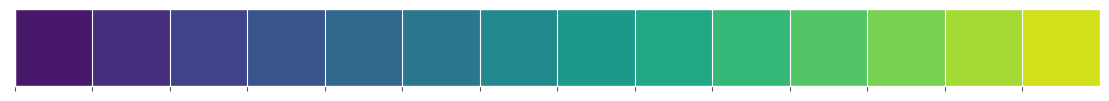

In [27]:
# Define the custom color palette
custom_palette = sns.color_palette("viridis", 14)
sns.palplot(custom_palette)

In [28]:
x5 = matches_MYI5["Average_MYI"]
y5 = matches_MYI5["Difference"]

slope5, intercept5, r5, *__ = stats.linregress(x5, y5)
line5 = f"Regression line: y={intercept5:.2f}+{slope5:.2f}x, r={r5:.2f}"

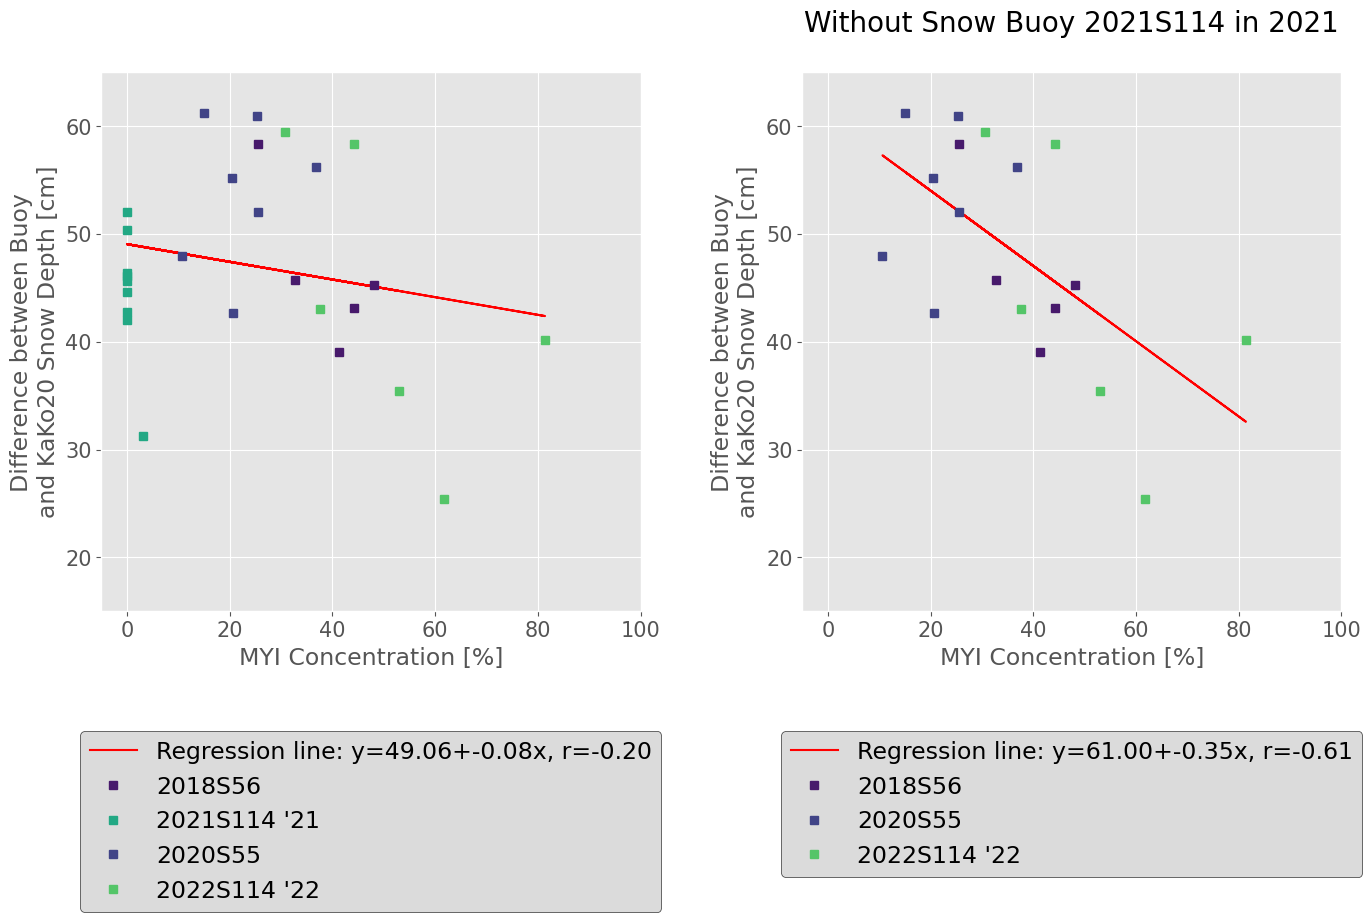

In [29]:
# Set the y-axis limits
x_limits = (-5, 100)
y_limits = (15, 65)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={"hspace": 0, "wspace": 0.3})  

x = matches_MYI["Average_MYI"]
y = matches_MYI["Difference"]

slope, intercept, r, *__ = stats.linregress(x, y)
line = f"Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}"

ax1.plot(x, intercept + slope * x, label=line, color="red")

ax1.plot(S56["Average_MYI"], S56["Difference"], linewidth=0, marker="s", c=custom_palette[0], label="2018S56")
ax1.plot(S114_2021["Average_MYI"], S114_2021["Difference"], linewidth=0, marker="s", c=custom_palette[8], label="2021S114 \'21")
ax1.plot(S55["Average_MYI"], S55["Difference"], linewidth=0, marker="s", c=custom_palette[2], label="2020S55")
ax1.plot(S114_2022["Average_MYI"], S114_2022["Difference"], linewidth=0, marker="s", c=custom_palette[10], label="2022S114 \'22")

ax1.set_xlabel("MYI Concentration [%]", fontsize=17)
ax1.set_ylabel("Difference between Buoy\nand KaKo20 Snow Depth [cm]", fontsize=17)

ax1.set_xlim(x_limits)
ax1.set_ylim(y_limits)
    

ax1.tick_params(axis="x", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)
    

ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), fontsize=17, ncol=1, frameon=True, facecolor="lightgrey", edgecolor="black")


ax2.plot(x5, intercept5 + slope5 * x5, label=line5, color="red")

ax2.plot(S56_5["Average_MYI"], S56_5["Difference"], linewidth=0, marker="s", c= custom_palette[0], label="2018S56")
ax2.plot(S55_5["Average_MYI"], S55_5["Difference"], linewidth=0, marker="s", c= custom_palette[2], label="2020S55")
ax2.plot(S114_2022_5["Average_MYI"], S114_2022_5["Difference"], linewidth=0, marker="s", c= custom_palette[10], label="2022S114 \'22")

ax2.set_xlabel("MYI Concentration [%]", fontsize=17)
ax2.set_ylabel("Difference between Buoy\nand KaKo20 Snow Depth [cm]", fontsize=17)
ax2.set_title("Without Snow Buoy 2021S114 in 2021\n", fontsize=20)

ax2.set_xlim(x_limits)
ax2.set_ylim(y_limits)
    
ax2.tick_params(axis="x", labelsize=15)
ax2.tick_params(axis="y", labelsize=15)


ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), fontsize=17, ncol=1, frameon=True, facecolor="lightgrey", edgecolor="black")


plt.savefig("MYI_comparison_and_regression.png", dpi=300, bbox_inches="tight")


plt.show()

### Calculate Pearson"s correlation coefficient and p-value

In [30]:
r, p = stats.pearsonr(matches_MYI["Average_MYI"], matches_MYI["Difference"])
print("Pearson's correlation coefficient:", r)
print("p-value:", p)

Pearson's correlation coefficient: -0.2049917489553496
p-value: 0.30502803062639444


In [31]:
r, p = stats.pearsonr(matches_MYI5["Average_MYI"], matches_MYI5["Difference"])
print("Pearson's correlation coefficient:", r)
print("p-value:", p)

Pearson's correlation coefficient: -0.6105184188215211
p-value: 0.007122961788661822


### Calculate Spearman"s correlation coefficient and p-value

In [32]:
corr, pval = spearmanr(matches_MYI["Average_MYI"], matches_MYI["Difference"])
print("Spearman's correlation coefficient:", corr)
print("p-value:", pval)

Spearman's correlation coefficient: -0.19451238437511692
p-value: 0.33094188108777856


In [33]:
corr, pval = spearmanr(matches_MYI5["Average_MYI"], matches_MYI5["Difference"])
print("Spearman's correlation coefficient:", corr)
print("p-value:", pval)

Spearman's correlation coefficient: -0.6057791537667698
p-value: 0.00771060824931586


<div class="alert alert-danger" role="alert" >
    

### <a id="section4.5"></a>Pearson and Spearman Correlation of only MYI Snow Buoys  
[Back to top](#TOC_TOP)

</div>

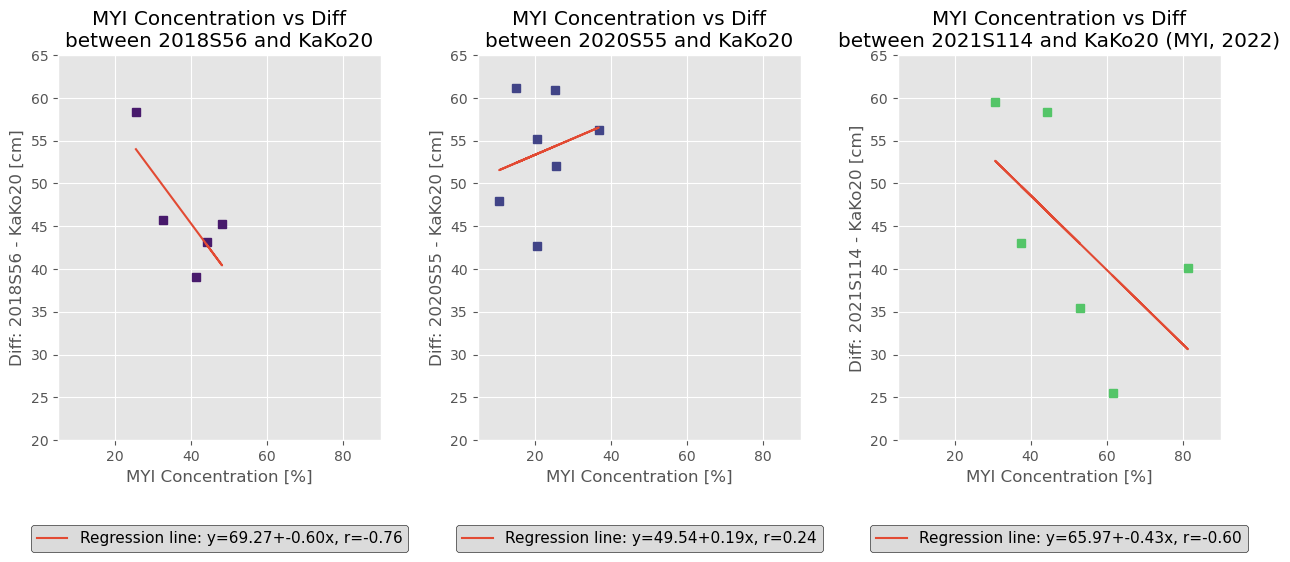

In [34]:
# Set the y-axis limits
x_limits = (5, 90)
y_limits = (20, 65)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.3})  


axs[0].plot(S56["Average_MYI"], S56["Difference"], linewidth=0, marker="s", c=custom_palette[0])

y = S56["Difference"]
x = S56["Average_MYI"]
slope, intercept, r, *__ = stats.linregress(x, y)
line = f"Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}"
axs[0].plot(x, intercept + slope * x, label=line)

axs[0].set_title("MYI Concentration vs Diff\nbetween 2018S56 and KaKo20")
axs[0].set_xlabel("MYI Concentration [%]")
axs[0].set_ylabel("Diff: 2018S56 - KaKo20 [cm]")
axs[0].set_xlim(x_limits)
axs[0].set_ylim(y_limits)
axs[0].legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), fontsize=11, ncol=1, frameon=True, facecolor="lightgrey", edgecolor="black")


axs[1].plot(S55["Average_MYI"], S55["Difference"], linewidth=0, marker="s", c=custom_palette[2])

y = S55["Difference"]
x = S55["Average_MYI"]
slope, intercept, r, *__ = stats.linregress(x, y)
line = f"Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}"
axs[1].plot(x, intercept + slope * x, label=line)

axs[1].set_title("MYI Concentration vs Diff\nbetween 2020S55 and KaKo20")
axs[1].set_xlabel("MYI Concentration [%]")
axs[1].set_ylabel("Diff: 2020S55 - KaKo20 [cm]")
axs[1].set_xlim(x_limits)
axs[1].set_ylim(y_limits)
axs[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), fontsize=11, ncol=1, frameon=True, facecolor="lightgrey", edgecolor="black")


axs[2].plot(S114_2022["Average_MYI"], S114_2022["Difference"], linewidth=0, marker="s", c=custom_palette[10])

y = S114_2022["Difference"]
x = S114_2022["Average_MYI"]
slope, intercept, r, *__ = stats.linregress(x, y)
line = f"Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}"
axs[2].plot(x, intercept + slope * x, label=line)

axs[2].set_title("MYI Concentration vs Diff\nbetween 2021S114 and KaKo20 (MYI, 2022)")
axs[2].set_xlabel("MYI Concentration [%]")
axs[2].set_ylabel("Diff: 2021S114 - KaKo20 [cm]")
axs[2].set_xlim(x_limits)
axs[2].set_ylim(y_limits)
axs[2].legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), fontsize=11, ncol=1, frameon=True, facecolor="lightgrey", edgecolor="black")


plt.savefig("MYI_per_buoy.png", dpi=300, bbox_inches="tight")  
plt.show()

### Calculate Pearson"s correlation coefficient and p-value

In [35]:
r, p = stats.pearsonr(S56["Average_MYI"], S56["Difference"])
print("Pearson's correlation coefficient:", r)
print("p-value:", p)

Pearson's correlation coefficient: -0.7605442907146518
p-value: 0.13549466954065545


In [36]:
r, p = stats.pearsonr(S114_2021["Average_MYI"], S114_2021["Difference"])
print("Pearson's correlation coefficient:", r)
print("p-value:", p)

Pearson's correlation coefficient: -0.8395209575495702
p-value: 0.004642192534597934


In [37]:
r, p = stats.pearsonr(S55["Average_MYI"], S55["Difference"])
print("Pearson's correlation coefficient:", r)
print("p-value:", p)

Pearson's correlation coefficient: 0.23633845844483936
p-value: 0.6098901180727417


In [38]:
r, p = stats.pearsonr(S114_2022["Average_MYI"], S114_2022["Difference"])
print("Pearson's correlation coefficient:", r)
print("p-value:", p)

Pearson's correlation coefficient: -0.600612656274605
p-value: 0.2074121879042985


### Calculate Spearman"s correlation coefficient and p-value

In [39]:
corr, pval = spearmanr(S56["Average_MYI"], S56["Difference"])
print("Spearman's correlation coefficient:", corr)
print("p-value:", pval)

Spearman's correlation coefficient: -0.6
p-value: 0.28475697986529375


In [40]:
corr, pval = spearmanr(S114_2021["Average_MYI"], S114_2021["Difference"])
print("Spearman's correlation coefficient:", corr)
print("p-value:", pval)

Spearman's correlation coefficient: -0.5477225575051661
p-value: 0.12687036692367104


In [41]:
corr, pval = spearmanr(S55["Average_MYI"], S55["Difference"])
print("Spearman's correlation coefficient:", corr)
print("p-value:", pval)

Spearman's correlation coefficient: 0.10714285714285716
p-value: 0.8191508555699912


In [42]:
corr, pval = spearmanr(S114_2022["Average_MYI"], S114_2022["Difference"])
print("Spearman's correlation coefficient:", corr)
print("p-value:", pval)

Spearman's correlation coefficient: -0.7714285714285715
p-value: 0.07239650145772594


<div class="alert alert-danger" role="alert">

### <a id="section4.6"></a>Pearson and Spearman Correlation between Snow Depth Difference and 0% MYI 
[Back to top](#TOC_TOP)

</div>


In [43]:
matches_MYI0 = matches_MYI[matches_MYI["Average_MYI"] == 0]

S114_2021_0 = matches_MYI0[(matches_MYI0["Sensor_Number"] == "S114") & (matches_MYI0["Year"] == 2021)]
S114_2021_0

,Year,Month,Day,X,Y,Snow_depth_satellite,Snow_depth_buoy,Mean_snow_accu,X_buoy,Y_buoy,Sensor_Number,lat_buoy,lon_buoy,lat_Kako20,lon_Kako20,Timestamp,Average_MYI,Difference
5,2021,4,1,-950.0,1250.0,4.23426,56.272,56.272,-947.114309,1257.867750,S114,-75.5392,-36.9780,-75.58042,-37.23483,2021-04-01,0.0,52.03774
6,2021,4,6,-950.0,1300.0,5.77390,56.108,56.108,-951.990407,1303.353240,S114,-75.1808,-36.1450,-75.21606,-36.15818,2021-04-06,0.0,50.33410
8,2021,4,26,-1000.0,1350.0,10.00154,56.343,58.800,-994.425999,1344.370448,S114,-74.6526,-36.4902,-74.58146,-36.52886,2021-04-26,0.0,46.34146
9,2021,5,29,-1100.0,1300.0,14.09222,59.694,63.765,-1090.551176,1311.021846,S114,-74.3522,-39.7548,-74.37370,-40.23636,2021-05-29,0.0,45.60178
12,2021,6,14,-1150.0,1325.0,12.01153,58.107,62.178,-1160.420045,1334.759992,S114,-73.7782,-41.0032,-73.90681,-40.95551,2021-06-14,0.0,46.09547
17,2021,7,9,-1200.0,1350.0,19.56157,62.345,NaN,-1204.630467,1349.143452,S114,-73.4160,-41.7612,-73.43808,-41.63354,2021-07-09,0.0,42.78343
18,2021,7,25,-1300.0,1400.0,15.78022,60.442,66.600,-1291.332347,1397.571922,S114,-72.5652,-42.7374,-72.49595,-42.87890,2021-07-25,0.0,44.66178
19,2021,9,12,-1475.0,1325.0,21.60654,63.586,72.815,-1483.265355,1325.270226,S114,-71.7874,-48.2198,-71.84449,-48.06649,2021-09-12,0.0,41.97946


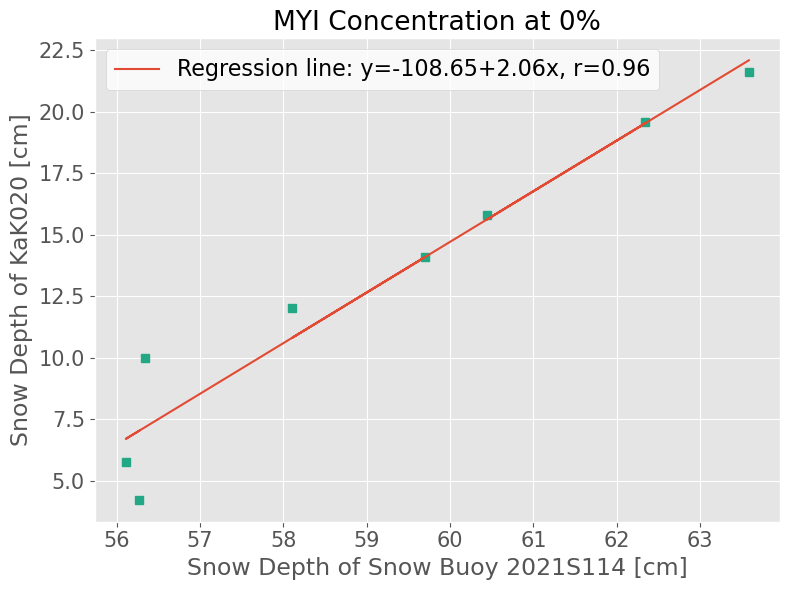

In [44]:
x0 = S114_2021_0["Snow_depth_buoy"]
y0 = S114_2021_0["Snow_depth_satellite"]

slope0, intercept0, r0, *__ = stats.linregress(x0, y0)
line0 = f"Regression line: y={intercept0:.2f}+{slope0:.2f}x, r={r0:.2f}"

fig, ax = plt.subplots(figsize=(8, 6)) 
ax.plot(S114_2021_0["Snow_depth_buoy"], S114_2021_0["Snow_depth_satellite"], linewidth=0, marker="s", c= custom_palette[8])
ax.plot(x0, intercept0 + slope0 * x0, label=line0)

ax.set_xlabel("Snow Depth of Snow Buoy 2021S114 [cm]", fontsize=17)
ax.set_ylabel("Snow Depth of KaK020 [cm]", fontsize=17)
ax.legend(facecolor="white", fontsize=16)

ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)

ax.set_title("MYI Concentration at 0%", fontsize=19)

plt.tight_layout()  
plt.savefig("MYI_all_under0.png", dpi=300)  
plt.show()

In [45]:
r, p = stats.pearsonr(S114_2021_0["Snow_depth_buoy"], S114_2021_0["Snow_depth_satellite"])
print("Pearson's correlation coefficient:", r)
print("p-value:", p)

Pearson's correlation coefficient: 0.9647499088384202
p-value: 0.00010662712149133352


In [46]:
corr, pval = spearmanr(S114_2021_0["Snow_depth_buoy"], S114_2021_0["Snow_depth_satellite"])
print("Spearman's correlation coefficient:", corr)
print("p-value:", pval)

Spearman's correlation coefficient: 0.9761904761904763
p-value: 3.3143960262001043e-05
